# parm@frosst-y to SMIRFF

This notebook provides examples/utility functionality to assist with conversion of parm@frosst or relatives to SMIRFF format. Particularly, Christopher Bayly is generating modified AMBER `frcmod` files where the first entry for each parameter (i.e. `CT-CT-CT`) is replaced by the relevant SMIRKS pattern, for conversion into SMIRFF FFXML format. 

This notebook will:
1. Convert a specified smirks-frcmod file to SMIRFF FFXML
2. Generate (or take in) a set of molecules in OpenEye oemol format
3. Use the SMIRFF `ForceField` class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter.

Bayly has also updates the notebook with visualization for 3(b) and 3(c).

Bannan added printed current atom types to make looking up references easier

**Authors**:
* David L. Mobley (UCI)
* Contributions from Christopher I. Bayly (OpenEye Scientific Software Inc.) and Caitlin C. Bannan (UCI)


In [1]:
# Imports
from __future__ import print_function
from convert_frcmod import *
import openeye.oechem as oechem
import openeye.oeiupac as oeiupac
import openeye.oeomega as oeomega
import openeye.oedepict as oedepict
from IPython.display import display
from smarty.forcefield import *
from smarty.forcefield_utils import get_molecule_parameterIDs
from smarty.utils import *
from smarty.sampler_smirky import *
% matplotlib inline
import matplotlib
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import time
import IPython
import pickle

# Relevant methods

In [16]:
def depictAtomByIdx(mol_copy, atomIdxList, supH = True, width=900, height=500):
    mol = oechem.OEMol(mol_copy)
    OEGenerate2DCoordinates(mol)
    atomBondSet = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.GetIdx() in atomIdxList:
            atomBondSet.AddAtom( atom)
            for bond in atom.GetBonds():
                nbrAtom = bond.GetNbr(atom)
                nbrIdx = nbrAtom.GetIdx()
                if (nbrIdx in atomIdxList) and nbrIdx>atom.GetIdx():
                    atomBondSet.AddBond( bond)
    from IPython.display import Image
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    aroStyle = oedepict.OEHighlightStyle_Color
    aroColor = oechem.OEColor(oechem.OEGrey)
    oedepict.OEAddHighlighting(disp, aroColor, aroStyle, 
                               oechem.OEIsAromaticAtom(), oechem.OEIsAromaticBond() )
    hstyle = oedepict.OEHighlightStyle_BallAndStick
    hcolor = oechem.OEColor(oechem.OELightGreen)
    oedepict.OEAddHighlighting(disp, hcolor, hstyle, atomBondSet)
    ofs = oechem.oeosstream()
    oedepict.OERenderMolecule(ofs, 'png', disp)
    ofs.flush()
    return Image(data = "".join(ofs.str()))

In [3]:
def getMolParamIDToAtomIndex( oemol, ff):
    """Take an OEMol and a SMIRFF forcefield object and return a dictionary,
    keyed by parameter ID, where each entry is a tuple of
    ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
    corresponding to that parameter ID and a list of the atom groups in that
    molecule that parameter is applied to.

    Parameters
    ----------
    oemol : OEMol
        OpenEye OEMol with the molecule to investigate.
    ff : ForceField
        SMIRFF ForceField object (obtained from an ffxml via ForceField(ffxml)) containing FF of interest.

    Returns
    -------
    param_usage : dictionary
        Dictionary, keyed by parameter ID, where each entry is a tuple of
        ( smirks, [[atom1, ... atomN], [atom1, ... atomN]) giving the SMIRKS
        corresponding to that parameter ID and a list of the atom groups in
        that molecule that parameter is applied to.

    """
    labels = ff.labelMolecules([oemol])
    param_usage = {}
    for mol_entry in range(len(labels)):
        for force in labels[mol_entry].keys():
            for (atom_indices, pid, smirks) in labels[mol_entry][force]:
                if not pid in param_usage:
                    param_usage[pid] = (smirks, [atom_indices])
                else:
                    param_usage[pid][1].append( atom_indices )

    return param_usage

In [4]:
def GetAtomInfo(mol, indices, skip_atoms = []):
    #print(indices)
    atoms_by_index = dict()
    charges_by_index = dict()
    for atom in mol.GetAtoms():
        idx = atom.GetIdx()
        if idx in indices:
            atoms_by_index[idx] = atom
            charge = atom.GetFormalCharge()
            if charge == 0:
                charges_by_index[idx] = ''
            elif charge > -1:
                charges_by_index[idx] = '+%i' % charge
            else:
                charges_by_index[idx] = str(charge)
    atoms = [(atoms_by_index[idx],charges_by_index[idx]) for idx in indices]
    types = [atom.GetType() for (atom,charge) in atoms]
    atom_smarts = ['[#%i%s]' % (atom.GetAtomicNum(),charge) for (atom,charge) in atoms]
    smarts = '~'.join(atom_smarts)
    types = '~'.join(types)
    
    for (atom, charge) in atoms:
        if atom.GetAtomicNum() in skip_atoms:
            return (True, smarts, types)
    

    return (False, smarts, types)
    
def DepictMolWithParam(mol, indice_list, supH = False, print_atoms = True, skip_atoms = []):
    skip_count = 0
    for IdxByOccurrence in indice_list:
        
        skip_it, approx_smarts, types = GetAtomInfo(mol, IdxByOccurrence, skip_atoms)
        
        if skip_it:
            skip_count += 1
            continue
            
        if print_atoms:
            print("Approximate SMARTS: %s" % approx_smarts)
            print("Current Atom Types: %s" % types)
        display(depictAtomByIdx(mol, IdxByOccurrence, supH = supH))
    if skip_count > 0:
        skips = ','.join([str(i) for i in skip_atoms])
        print("This molecule contains %i fragment(s) with at least one atom in (%s)" % (skip_count, skips))

In [5]:
def make_param_histogram(param_id_counts, param_ids, letter, title):
    # Graph occurrences of bond parameters
    parm_ids = [ pid for pid in param_ids if pid[0]==letter]
    parm_ids.sort()
    counts_parms = [param_id_counts[parm_id] for parm_id in parm_ids]
    #print( parm_ids)
    #print( counts_parms)
    split = int(len(parm_ids)/2)
    
    indices = np.arange(len(parm_ids))
    fix, ax = plt.subplots(2,1,figsize=(16,5))
    ax[0].set_yscale('log', nonposy='clip')
    ax[1].set_yscale('log', nonposy='clip')
    
    rects2 = ax[0].bar(indices[0:split], counts_parms[0:split] )
    ax[0].set_ylabel('Count')
    ax[0].set_xticks( indices[0:split])
    ax[0].set_xticklabels( parm_ids[0:split], rotation=-60, ha='left')
    ax[0].set_xlim(indices[0], indices[split])
    plt.yscale('log',nonposy='clip')
    rects2 = ax[1].bar(indices[split:], counts_parms[split:])
    ax[1].set_ylabel('Count')
    ax[1].set_xticks( indices[split:])
    ax[1].set_xticklabels( parm_ids[split:], rotation=-60, ha='left')
    ax[1].set_xlim(indices[split], indices[-1]+1)
    
    ax[0].set_title(title)
    plt.show()

## 1. Convert specified SMIRKS `frcmod` file to SMIRFF FFXML

In [22]:
# Input and output info
#infile = 'example.frcmod' # smirffish frcmod file to convert
infile = 'smirffishFrcmod.parm99Frosst.txt' # smirffish frcmod file to convert
smirffFilename = 'smirff99Frosst'
ffxmlFile = smirffFilename+'.ffxml'
template = 'template.ffxml' # Template FFXML file without parameters (but with remainder of contents)

In [23]:
# Convert
# Already converted
convert_frcmod_to_ffxml( infile, template, ffxmlFile)

In [8]:
# Load SMIRFF FFXML
ff = ForceField(ffxmlFile) # We will use this below to access details of parameters

## 2. Generate or take in a set of molecules in OpenEye OEMol format

Here we will take in the ZINC parm@frosst subset from CCL (which is also packaged with SMARTY) and read all the molecules from it.

In [9]:
import glob
#DBpath = "/Users/bannanc/Google Drive/Mobley Group/Research/Ongoing Projects/off-forcefieldcompare/DrugBank/setup_mol2/GAFF2/*.mol2"
#drugbank_files = glob.glob(DBpath)
#molecules = list()
#for f in drugbank_files:
#    molecules += read_molecules(f, verbose=False)

mol_File = '/Users/bannanc/gitHub/SMIRFF/smarty/smarty/data/molecules/MiniDrugBank_ff.mol2'
mol_File = 'DrugBank_atyped.oeb'
molecules = read_molecules(mol_File)
# For use later, generate isomeric SMILES for these so we can easily look up molecules by smiles
isosmiles_to_mol = {}
for mol in molecules:
    # skip molecules with metals
    if OECount(mol, OEIsMetal()) > 0:
        continue
    smi = oechem.OECreateIsoSmiString(mol)
    c_mol = OEMol(mol)
    OEAddExplicitHydrogens(c_mol)
    isosmiles_to_mol[smi] = c_mol

oemols = [mol for smi, mol in isosmiles_to_mol.items()]
print("After filtering repeated SMILES there are %i/%i molecules" % (len(oemols), len(molecules)))

Loading molecules from '/Users/bannanc/anaconda/lib/python2.7/site-packages/smarty/data/molecules/DrugBank_atyped.oeb'...
7133 molecules read
2.320 s elapsed
After filtering repeated SMILES there are 6814/7133 molecules


## 3. Determine parameter usage in molecules

Here we will use the SMIRFF ForceField class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter. We begin by just loading the SMIRFF forcefield we generated in section 1.

### 3(a). Determine which parameters are used in which molecules

Here we determine which parameters are actually used in which molecules, and make a couple example plots of the frequency of parameter occurrences for some of our example parameters.

In [10]:
# Track time
init_time = time.time()
# label molecules
labels = ff.labelMolecules(oemols, verbose = False)
elapsed = (time.time() - init_time) / 60.0
print("Assigned labels took %.2f minutes" % (elapsed))

Assigned labels took 11.49 minutes


In [11]:
# organize dictionaries to reference information 
init_time = time.time()
parameters_by_molecule = dict()
parameters_by_ID = dict()
param_ids = set()
param_id_counts = dict()
for idx, mol_dict in enumerate(labels):
    smi = OECreateIsoSmiString(oemols[idx])
    parameters_by_molecule[smi] = dict()
    for force_type, label_set in mol_dict.items():
        for (indices, pid, smirks) in label_set:
            if not parameters_by_molecule[smi].has_key(pid):
                parameters_by_molecule[smi][pid] = list()
            parameters_by_molecule[smi][pid].append(indices)
            
            if not parameters_by_ID.has_key(pid):
                parameters_by_ID[pid] = set()
            parameters_by_ID[pid].add(smi)
            
            param_ids.add(pid)

for pid in param_ids:
    param_id_counts[pid] = 0
    
for smi, pid_dict in parameters_by_molecule.items():
    for pid, ind_list in pid_dict.items():
        param_id_counts[pid] += len(ind_list)   

elapsed = (time.time() - init_time) / 60.0
print("Organizing dictionaries took %.2f minutes" % (elapsed))

Organizing dictionaries took 0.10 minutes


For fun/info, do a quick graph of frequency of occurrence of particular parameters. Here, let's just do bond parameters

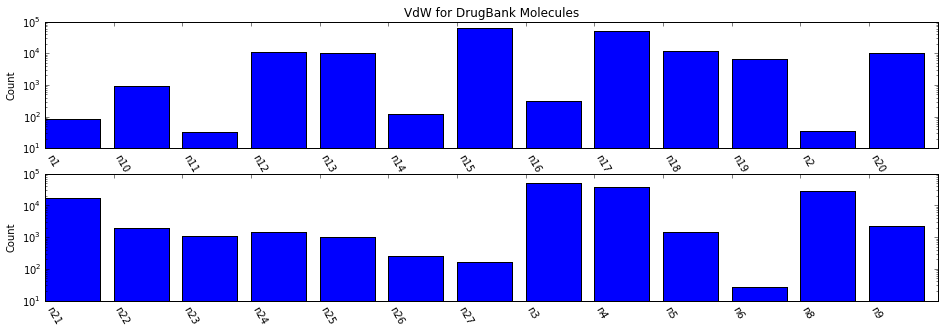

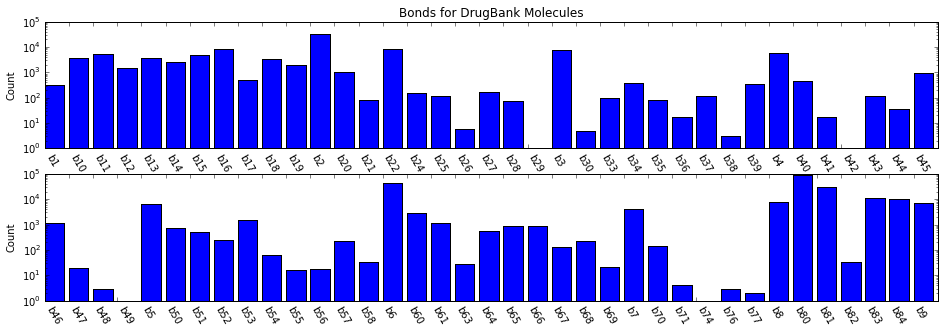

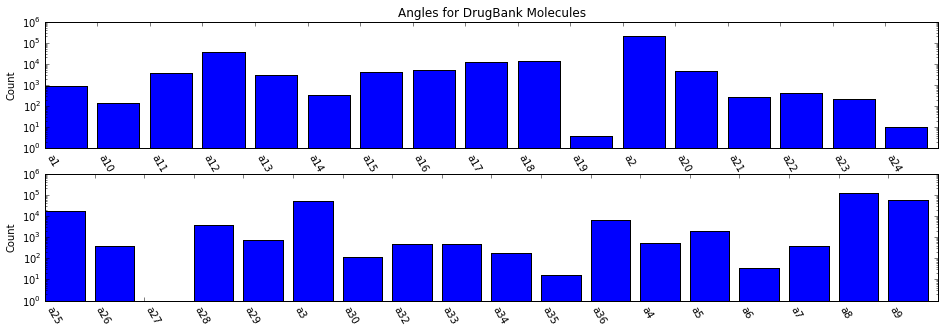

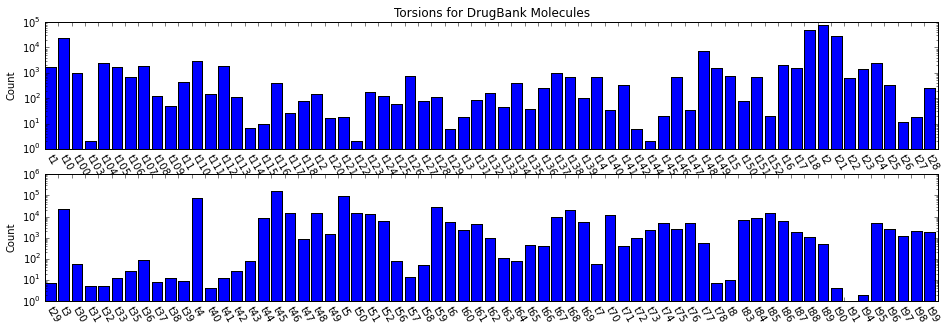

In [12]:
# Create Hisogram for each type of parameter
# VdW
make_param_histogram(param_id_counts, param_ids, 'n', "VdW for DrugBank Molecules")
# Bonds
make_param_histogram(param_id_counts, param_ids, 'b', "Bonds for DrugBank Molecules")
# Angles
make_param_histogram(param_id_counts, param_ids, 'a', "Angles for DrugBank Molecules")
# Torsions
make_param_histogram(param_id_counts, param_ids, 't', "Torsions for DrugBank Molecules")
#make_param_histogram(param_id_counts, param_ids, 'i', "Impropers for DrugBank Molecules")

### 3(b)-3(c). Determine which molecules do/do not contain selected parameter

Determine which molecules do and do not contain a specified parameter; give access to isomeric smiles and OEMol for each molecule in each case.

In [19]:
# INPUT: Pick what parameter to look at
parameter_id = 'b1' 

# For info, get details of that parameter
params = ff.getParameter(paramID=parameter_id)
print("For parameter %s, the relevant parameters are:" % parameter_id)
print(params)

# Find molecules which do/do not use that parameter
mols_with_param = []
mols_wo_param = []
for isosmi in parameters_by_molecule:
    # Store a tuple of (isomeric smiles, oemol) for each
    if parameter_id in parameters_by_molecule[isosmi].keys():
        mols_with_param.append( (isosmi, isosmiles_to_mol[isosmi] ))
    else:
        mols_wo_param.append( (isosmi, isosmiles_to_mol[isosmi] ))

print("\nThere are %s molecules containing that parameter and %s which do not, out of %s.\n" % 
      (len(mols_with_param), len(mols_wo_param), len(isosmiles_to_mol)))

# Print first 10 molecules not containing parameter
print("First 10 molecules not containing '%s' parameter:" % parameter_id)
for i in range(10):
    print("   %s" % mols_wo_param[i][0])
# Print first 10 molecules containing parameter
containing = min(10,len(mols_with_param))
if len(mols_with_param) == 0:
    print("\nNO molecules contain '%s' parameter" % parameter_id)
elif len(mols_with_param) <= 10:
    print("\nThe %i molecule(s) containing '%s' parameter:" % (containing, parameter_id))
else:
    print("\nFirst 10 molecules containing '%s' parameter:" % parameter_id)

for i in range(containing):
    print("   %s" % mols_with_param[i][0])

For parameter b1, the relevant parameters are:
{'smirks': '[*:1]~[*:2]', 'k': '2000.0', 'length': '4.0', 'id': 'b1'}

There are 115 molecules containing that parameter and 6699 which do not, out of 6814.

First 10 molecules not containing 'b1' parameter:
   CC(C)(C)NC(=O)[C@@H]1CN(CCN1C[C@H](C[C@@H](Cc2ccccc2)C(=O)N[C@H]3c4ccccc4C[C@H]3O)O)Cc5cccnc5
   C[C@]12CCC(=O)C=C1CC[C@@H]3[C@@]2([C@H](C[C@]4([C@H]3CC[C@@]4(C(=O)CO)O)C)O)F
   CC(C)(C)OC(=O)Nc1cccnc1C(=O)Nc2nccs2
   c1cc(ccc1c2ccc3c(c2)ccc(c3Cl)O)O
   CN1CCCC(CC1)n2c(=O)c3ccccc3c(n2)Cc4ccc(cc4)Cl
   c1cn(c(=O)[nH]c1=O)[C@H]2C[C@@H]([C@H](O2)CO)OP(=O)(O)O
   CO/C=C(\c1ccccc1Oc2cc(ncn2)Oc3ccccc3C#N)/C(=O)OC
   C1CN(C1=O)[C@H](CCCNC(=N)N)C(=O)O
   CCOC(=O)C1(CCN(CC1)C)c2ccccc2
   C1=C[C@H]([C@@H](C(=C1)C(=O)O)N)O

First 10 molecules containing 'b1' parameter:
   B([C@H](Cc1cccc(c1)C(=O)O)NC(=O)C)(O)O
   CCC(=O)Nc1c(cc(cc1C)C(=O)N2CCC(CC2)N(C)CCc3ccccc3)C.O.Cl
   C([C@@H](C(=O)O)N)S[As](=O)(O)O
   B(c1ccc(cc1)C(=O)O)(O)O
   [C]#O
   [


Depicting molecules 0 to 115 with parameter 'b1'


looking at molecule 0
Selected smiles is B([C@H](Cc1cccc(c1)C(=O)O)NC(=O)C)(O)O
Selected IUPAC name guessed: 3-[(2~{R})-2-acetamido-2-borono-ethyl]benzoic acid
mol title and NumAtoms:  BJI 32
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 1
Selected smiles is CCC(=O)Nc1c(cc(cc1C)C(=O)N2CCC(CC2)N(C)CCc3ccccc3)C.O.Cl
Selected IUPAC name guessed: ~{N}-[2,6-dimethyl-4-[4-[methyl(2-phenylethyl)amino]piperidine-1-carbonyl]phenyl]propanamide;hydrate;hydrochloride
mol title and NumAtoms:   71
Number of times 'b1' appears:   1
Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


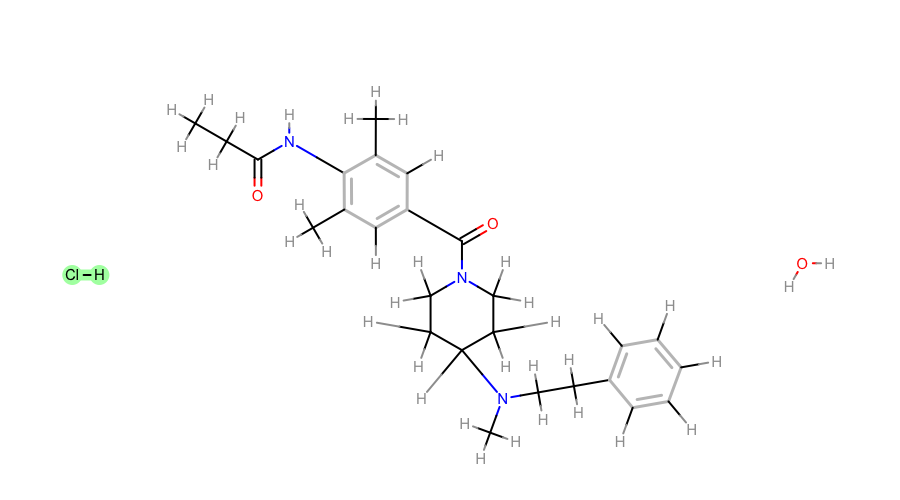




looking at molecule 2
Selected smiles is C([C@@H](C(=O)O)N)S[As](=O)(O)O
Selected IUPAC name guessed: (2~{R})-2-amino-3-arsonosulfanyl-propanoic acid
mol title and NumAtoms:   19
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 3
Selected smiles is B(c1ccc(cc1)C(=O)O)(O)O
Selected IUPAC name guessed: 4-boronobenzoic acid
mol title and NumAtoms:   19
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 4
Selected smiles is [C]#O
Selected IUPAC name guessed: $l^{3}-oxidanylidynemethane
mol title and NumAtoms:   2
Number of times 'b1' appears:   1
Approximate SMARTS: [#6]~[#8]
Current Atom Types: C2~Ou


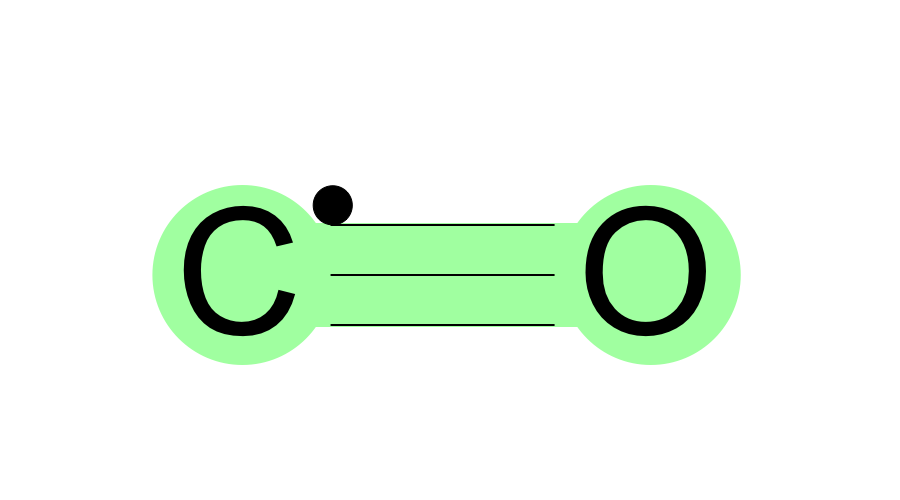




looking at molecule 5
Selected smiles is [B-]([C@@H](Cc1ccc(cc1)Cl)NC(=O)C)(O)(O)O
Selected IUPAC name guessed: [(1~{S})-1-acetamido-2-(4-chlorophenyl)ethyl]-trihydroxy-boranuide
mol title and NumAtoms:  V35 31
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 6
Selected smiles is CC[C@@]1(c2cc-3n(c(=O)c2COC1=O)Cc4c3nc5ccccc5c4CC[Si](C)(C)C)O
Selected IUPAC name guessed: (19~{S})-19-ethyl-19-hydroxy-10-(2-trimethylsilylethyl)-17-oxa-3,13-diazapentacyclo[11.8.0.0^{2,11}.0^{4,9}.0^{15,20}]henicosa-1(21),2,4,6,8,10,15(20)-heptaene-14,18-dione
mol title and NumAtoms:   60
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 7
Selected smiles is [B-]1(n2c(ccc2CCCCCCCC)C=c3[n+]1c(cc3)CCCCC(=O)O)(F)F
Selected IUPAC name guessed: 5-(2,2-difluoro-12-octyl-1-aza-3-azonia-2-boranuidatricyclo[7.3.0.0^{3,7}]dodeca-3,5,7,9,11-pentae

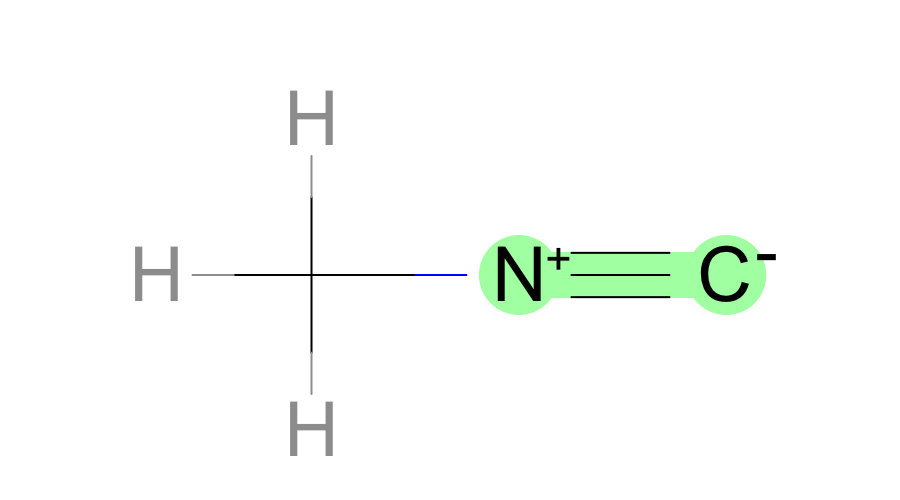




looking at molecule 10
Selected smiles is c1[nH]c(=[Se])c2c(n1)n(cn2)[C@H]3[C@@H]([C@H]([C@@H](O3)CO)O)O
Selected IUPAC name guessed: 9-[(2~{R},3~{R},4~{R},5~{S})-3,4-dihydroxy-5-(hydroxymethyl)tetrahydrofuran-2-yl]-1~{H}-purine-6-selone
mol title and NumAtoms:   31
Number of times 'b1' appears:   1
This molecule contains 1 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 11
Selected smiles is B(CCSC[C@@H](C(=O)O)N)(O)(O)O
Selected IUPAC name guessed: 2-[(2~{R})-2-amino-2-carboxy-ethyl]sulfanylethyl-trihydroxy-boron
mol title and NumAtoms:   26
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 12
Selected smiles is B([C@@H]1CCCN1C(=O)[C@@H]2CCCN2)(O)O
Selected IUPAC name guessed: [(2~{R})-1-[(2~{S})-pyrrolidine-2-carbonyl]pyrrolidin-2-yl]boronic acid
mol title and NumAtoms:  BPR 32
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one ato

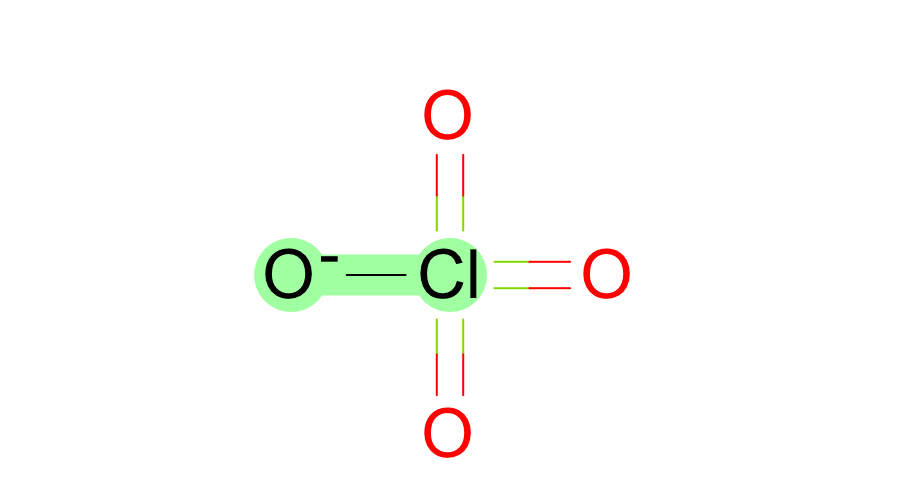

Approximate SMARTS: [#17]~[#8]
Current Atom Types: CL~Ou


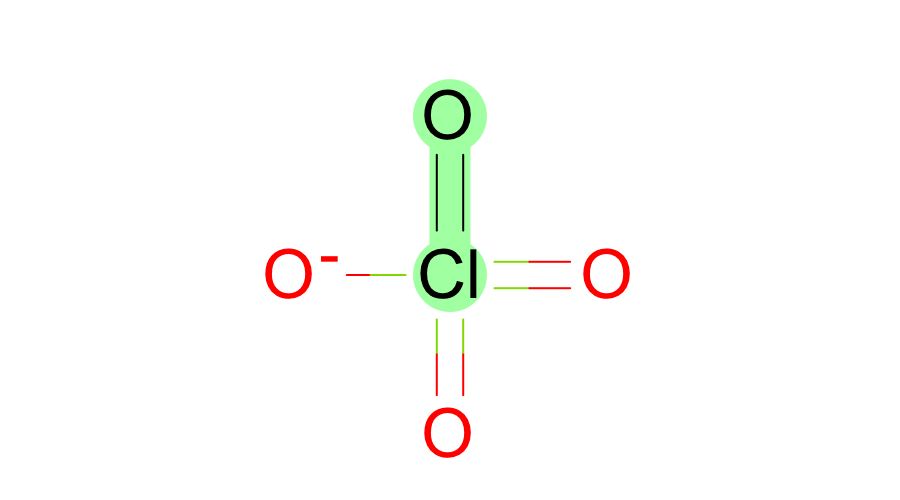

Approximate SMARTS: [#17]~[#8]
Current Atom Types: CL~Ou


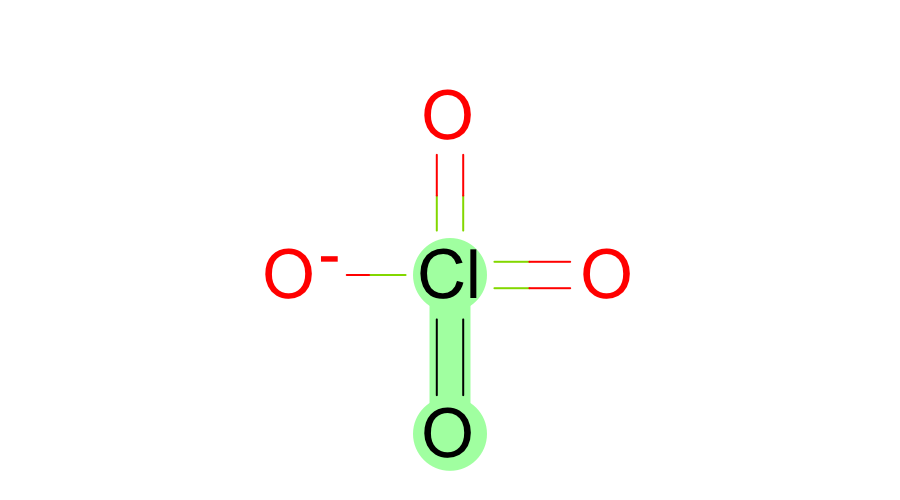

Approximate SMARTS: [#17]~[#8]
Current Atom Types: CL~Ou


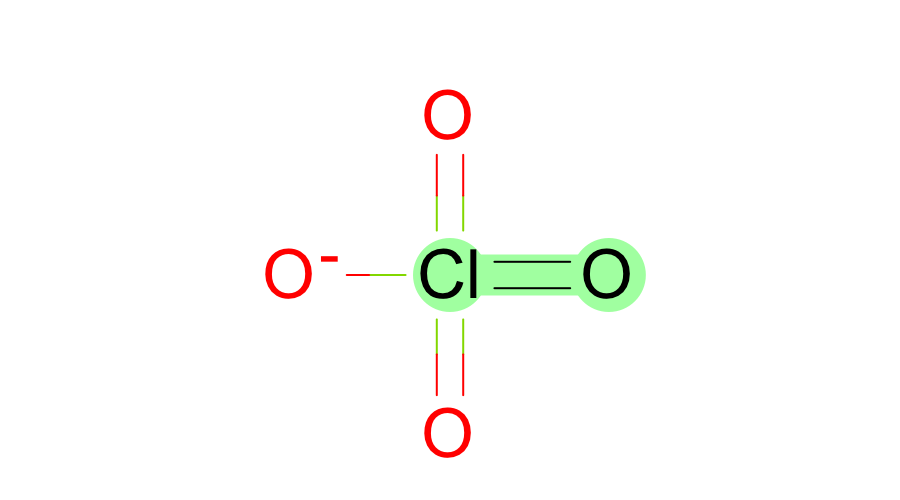




looking at molecule 17
Selected smiles is B1(c2cc(sc2C=NN1S(=O)(=O)CCC)C)O
Selected IUPAC name guessed: 1-hydroxy-6-methyl-2-propylsulfonyl-thieno[3,2-d]diazaborinine
mol title and NumAtoms:  Structure #1 30
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 18
Selected smiles is B1(OC[C@H](O1)CO)c2ccc(cc2)CCNC(=N)N
Selected IUPAC name guessed: 1-[2-[4-[(4~{R})-4-(hydroxymethyl)-1,3,2-dioxaborolan-2-yl]phenyl]ethyl]guanidine
mol title and NumAtoms:  412 37
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 19
Selected smiles is B1(OCCO1)O
Selected IUPAC name guessed: 2-hydroxy-1,3,2-dioxaborolane
mol title and NumAtoms:   11
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 20
Selected smiles is C([C@@H](C(=O)O)N)[SeH]
Selected IUPAC 

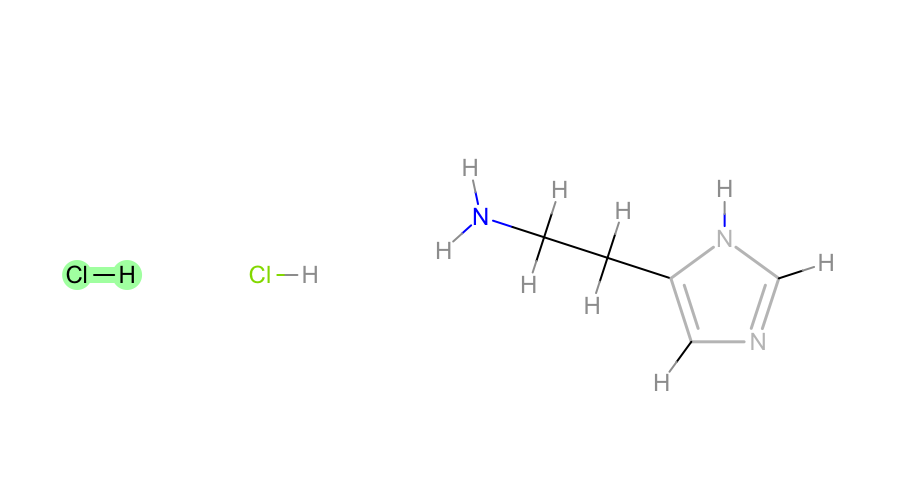

Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


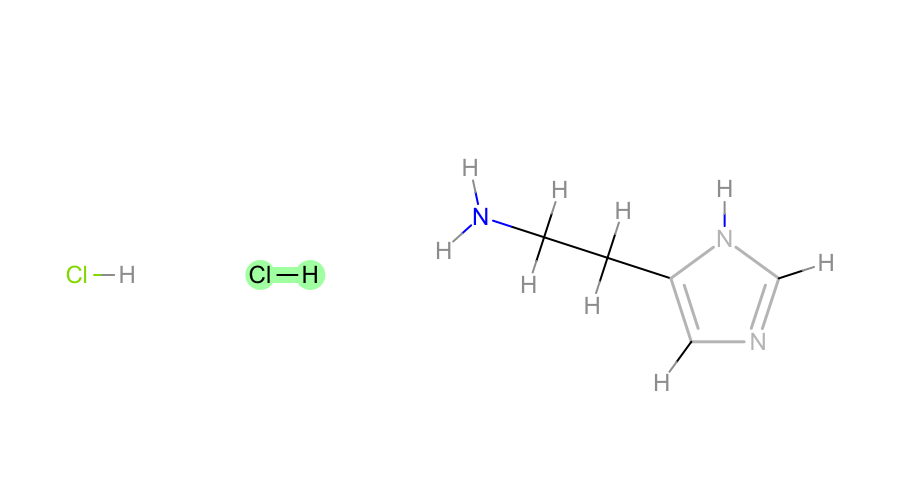




looking at molecule 22
Selected smiles is O.[O-]Cl=O.[O-]Cl=O.[O-]Cl=O.[O-]Cl=O.O=O
Selected IUPAC name guessed: molecular oxygen;tetrachlorite;hydrate
mol title and NumAtoms:   17
Number of times 'b1' appears:   9
Approximate SMARTS: [#17]~[#8-1]
Current Atom Types: CL~O2


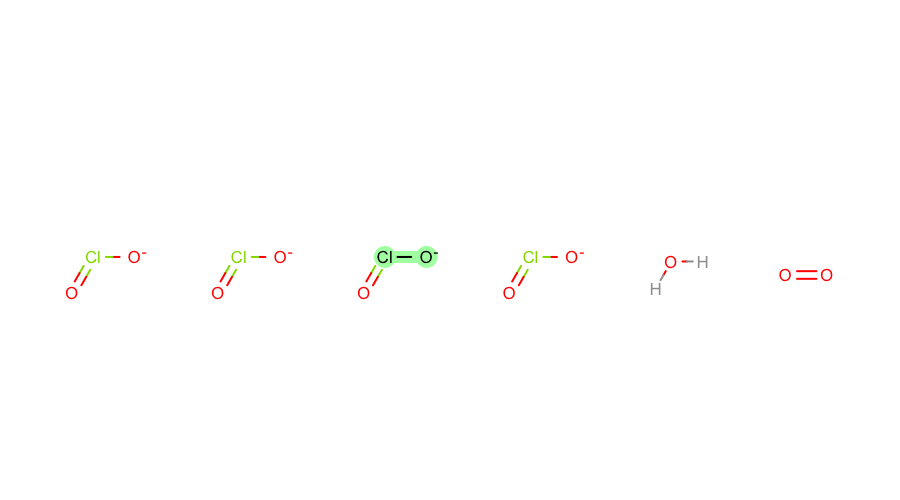

Approximate SMARTS: [#8]~[#8]
Current Atom Types: Ou~Ou


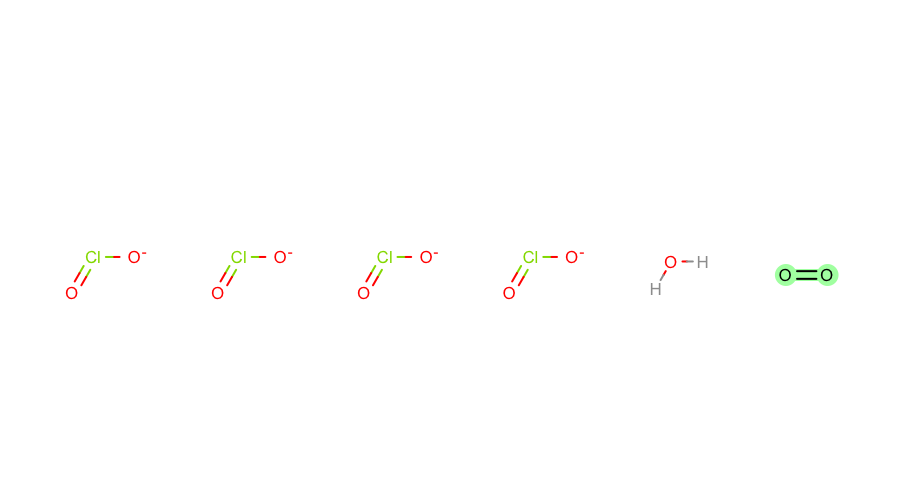

Approximate SMARTS: [#17]~[#8]
Current Atom Types: CL~Ou


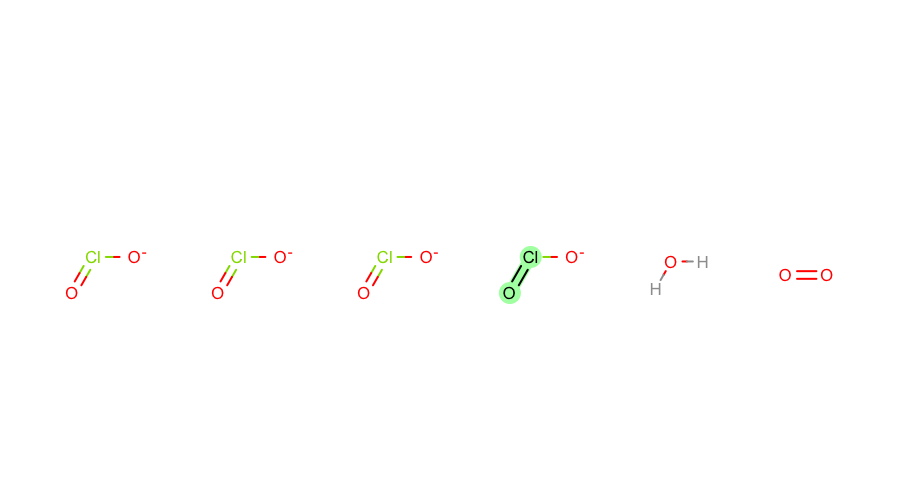

Approximate SMARTS: [#17]~[#8]
Current Atom Types: CL~Ou


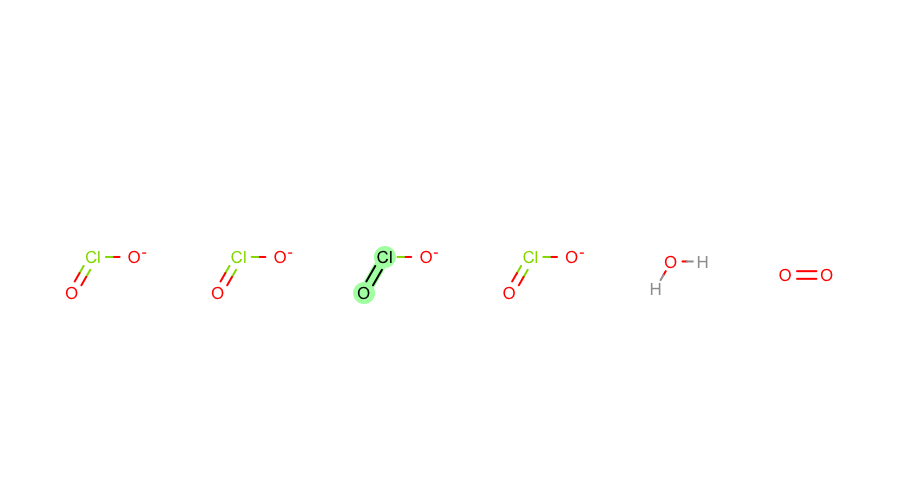

Approximate SMARTS: [#17]~[#8-1]
Current Atom Types: CL~O2


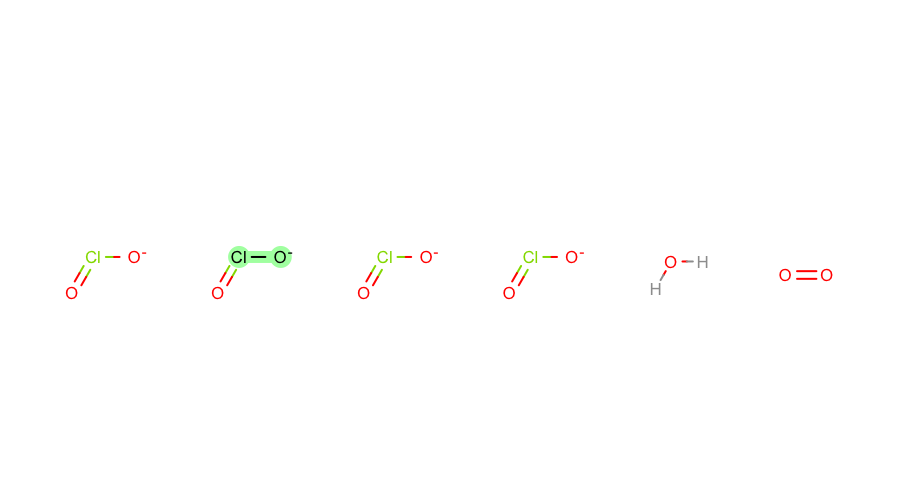

Approximate SMARTS: [#17]~[#8]
Current Atom Types: CL~Ou


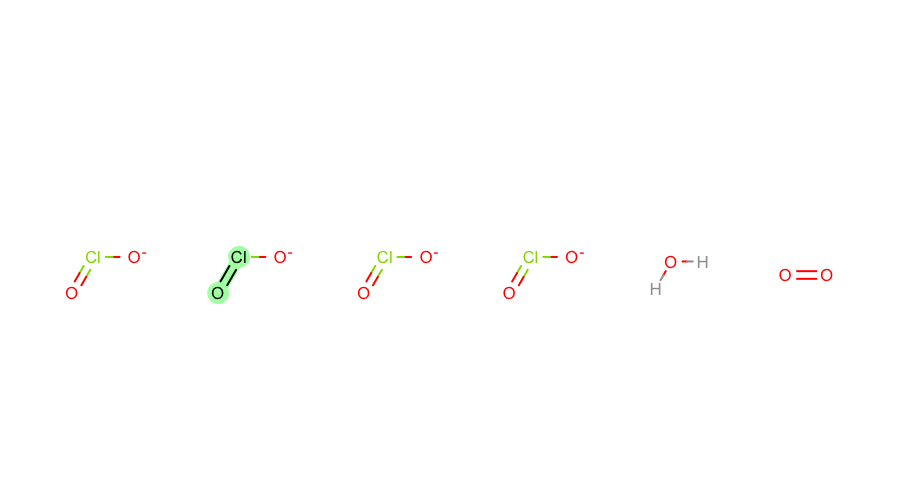

Approximate SMARTS: [#17]~[#8-1]
Current Atom Types: CL~O2


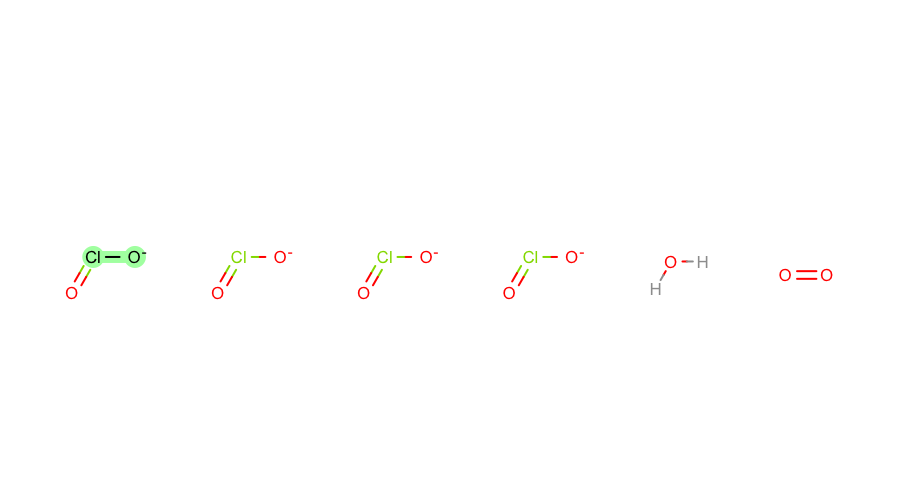

Approximate SMARTS: [#17]~[#8-1]
Current Atom Types: CL~O2


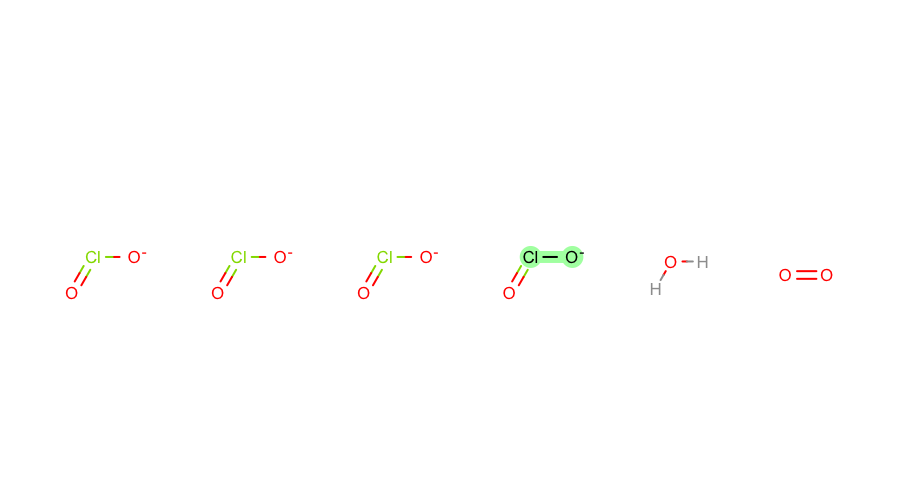

Approximate SMARTS: [#17]~[#8]
Current Atom Types: CL~Ou


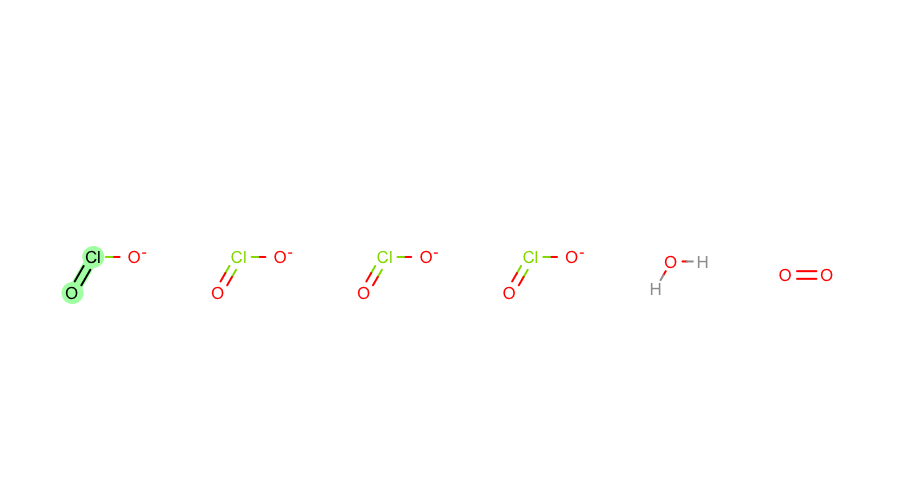




looking at molecule 23
Selected smiles is B(CNC(=O)/C(=N\OC)/c1csc(n1)N)(O)O
Selected IUPAC name guessed: [[(2~{Z})-2-(2-aminothiazol-4-yl)-2-methoxyimino-acetyl]amino]methylboronic acid
mol title and NumAtoms:  CXB 28
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 24
Selected smiles is c1cn(c(=S)nc1N)[C@]2([C@H]([C@@H]([C@H](O2)CO)O)O)O.Cl
Selected IUPAC name guessed: 4-amino-1-[(2~{R},3~{S},4~{S},5~{R})-2,3,4-trihydroxy-5-(hydroxymethyl)tetrahydrofuran-2-yl]pyrimidine-2-thione;hydrochloride
mol title and NumAtoms:   33
Number of times 'b1' appears:   1
Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


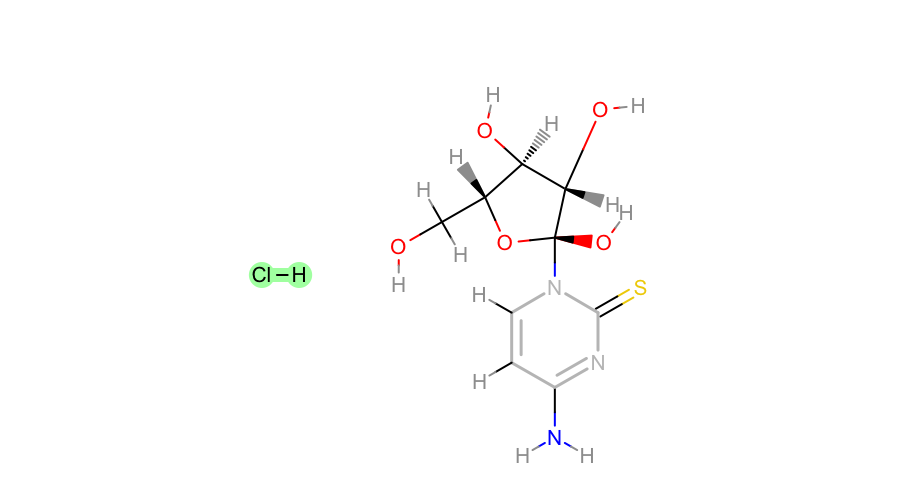




looking at molecule 25
Selected smiles is CC[Si](C)(C)C
Selected IUPAC name guessed: ethyl(trimethyl)silane
mol title and NumAtoms:   20
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 26
Selected smiles is B(c1cc2ccccc2s1)(O)O
Selected IUPAC name guessed: benzothiophen-2-ylboronic acid
mol title and NumAtoms:   19
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 27
Selected smiles is B([C@H](CCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](Cc2ccccc2)NC(=O)C)(O)O
Selected IUPAC name guessed: [(1~{R})-1-[[(2~{S})-1-[(2~{R})-2-acetamido-3-phenyl-propanoyl]pyrrolidine-2-carbonyl]amino]-5-amino-pentyl]boronic acid
mol title and NumAtoms:  DI2 64
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 28
Selected smiles is B([C@H](Cc1ccccc1)N)(O)O
Selec

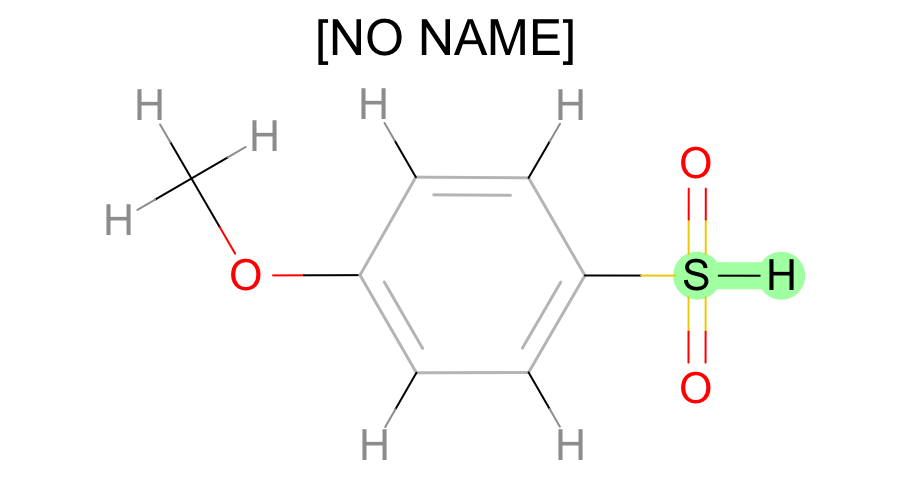




looking at molecule 32
Selected smiles is c1c(nc([se]1)[C@H]2[C@@H]([C@H]([C@@H](O2)CO[P@@](=O)(O)O[P@](=O)(O)OC[C@H]3[C@@H]([C@H]([C@@H](O3)n4cnc5c4ncnc5N)O)O)O)O)C(=O)N
Selected IUPAC name guessed: [[(2~{S},3~{R},4~{R},5~{R})-5-(6-aminopurin-9-yl)-3,4-dihydroxy-tetrahydrofuran-2-yl]methoxy-hydroxy-phosphoryl] [(2~{S},3~{R},4~{R},5~{R})-5-(4-carbamoyl-1,3-selenazol-2-yl)-3,4-dihydroxy-tetrahydrofuran-2-yl]methyl hydrogen phosphate
mol title and NumAtoms:   68
Number of times 'b1' appears:   2
This molecule contains 2 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 33
Selected smiles is O[As](O)O
Selected IUPAC name guessed: arsorous acid
mol title and NumAtoms:   7
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 34
Selected smiles is B(c1cccc(c1)NC(=O)CI)(O)O
Selected IUPAC name guessed: [3-[(2-iodoacetyl)amino]phenyl]boronic acid
mol title and NumAtoms:  IAP 23
Number

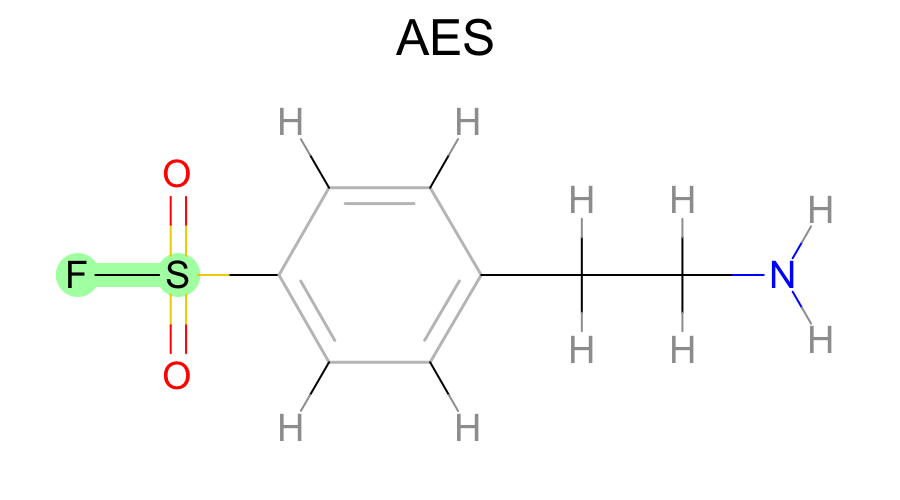




looking at molecule 39
Selected smiles is [B-](CCCC[C@@H](C(=O)O)N)(O)(O)O
Selected IUPAC name guessed: [(5~{S})-5-amino-5-carboxy-pentyl]-trihydroxy-boranuide
mol title and NumAtoms:   28
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 40
Selected smiles is C[As](=O)(C)SC[C@H](C(=O)O)N
Selected IUPAC name guessed: (2~{S})-2-amino-3-dimethylarsorylsulfanyl-propanoic acid
mol title and NumAtoms:   23
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 41
Selected smiles is O=[As][As](=O)=O
Selected IUPAC name guessed: BLAH
mol title and NumAtoms:   5
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 42
Selected smiles is B(c1cccc(c1)N)(O)O
Selected IUPAC name guessed: (3-aminophenyl)boronic acid
mol title and NumAtoms:   18
Number of

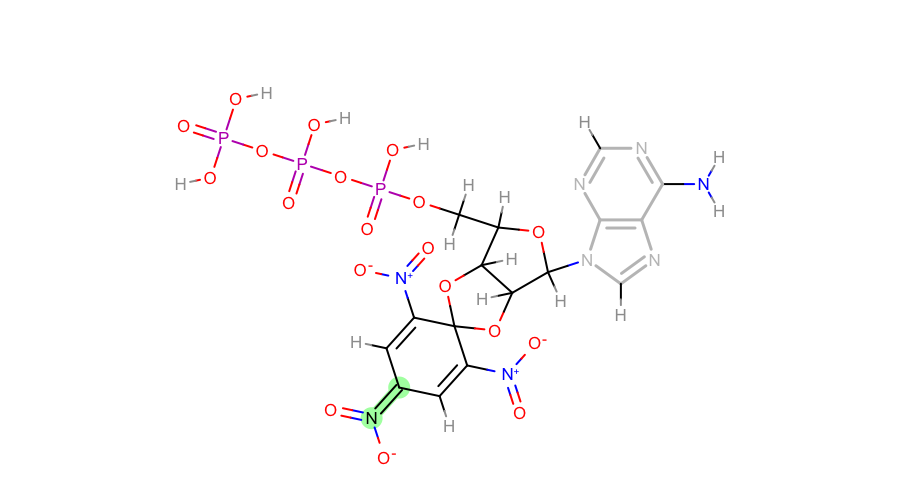




looking at molecule 44
Selected smiles is CCCC[N+]#[C-]
Selected IUPAC name guessed: 1-isocyanobutane
mol title and NumAtoms:   15
Number of times 'b1' appears:   1
Approximate SMARTS: [#7+1]~[#6-1]
Current Atom Types: NL~C2


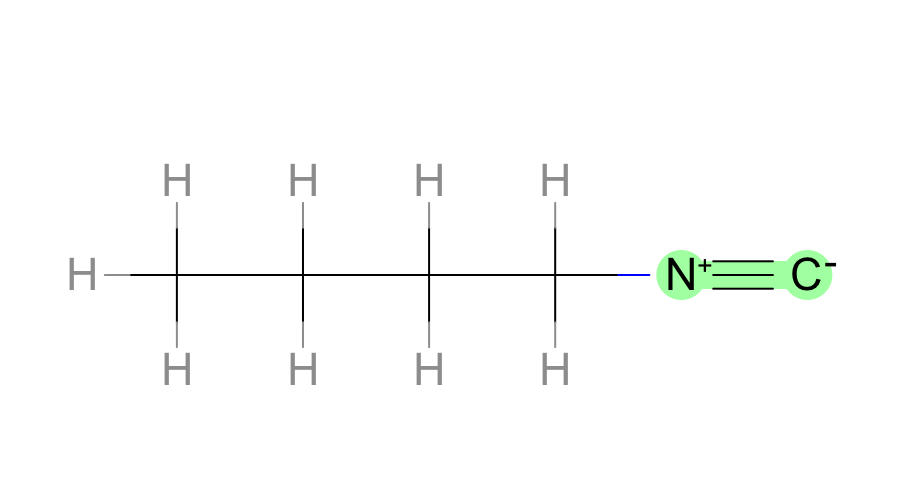




looking at molecule 45
Selected smiles is [B-]([C@H](Cc1cccc2c1cccc2)NC(=O)C)(O)(O)O
Selected IUPAC name guessed: [(1~{R})-1-acetamido-2-(1-naphthyl)ethyl]-trihydroxy-boranuide
mol title and NumAtoms:  SRB 37
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 46
Selected smiles is CC/N=C\1/Nc2ccc(cc2C(O1)(C)c3ccccc3)Cl.Cl
Selected IUPAC name guessed: (~{Z})-6-chloro-~{N}-ethyl-4-methyl-4-phenyl-1~{H}-3,1-benzoxazin-2-imine;hydrochloride
mol title and NumAtoms:   40
Number of times 'b1' appears:   1
Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


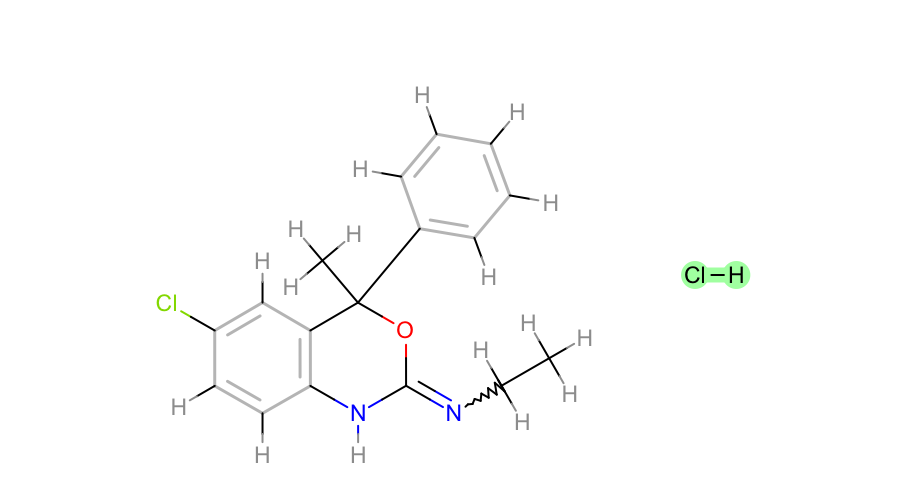




looking at molecule 47
Selected smiles is B(CCc1ccccc1)(O)O
Selected IUPAC name guessed: 2-phenylethylboronic acid
mol title and NumAtoms:   22
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 48
Selected smiles is c1c[se]c2=NCC(=c21)C[C@@H](C(=O)O)N
Selected IUPAC name guessed: (2~{S})-2-amino-3-(5~{H}-selenopheno[2,3-b]pyrrol-4-yl)propanoic acid
mol title and NumAtoms:   24
Number of times 'b1' appears:   2
This molecule contains 2 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 49
Selected smiles is B([C@H](c1cccc(c1)C(=O)O)NC(=O)Cc2cccs2)(O)O
Selected IUPAC name guessed: 3-[(~{R})-borono-[[2-(2-thienyl)acetyl]amino]methyl]benzoic acid
mol title and NumAtoms:  SM2 36
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 50
Selected smiles is S=[Se]=S
Selected IUPAC name guessed: BLAH
mol 

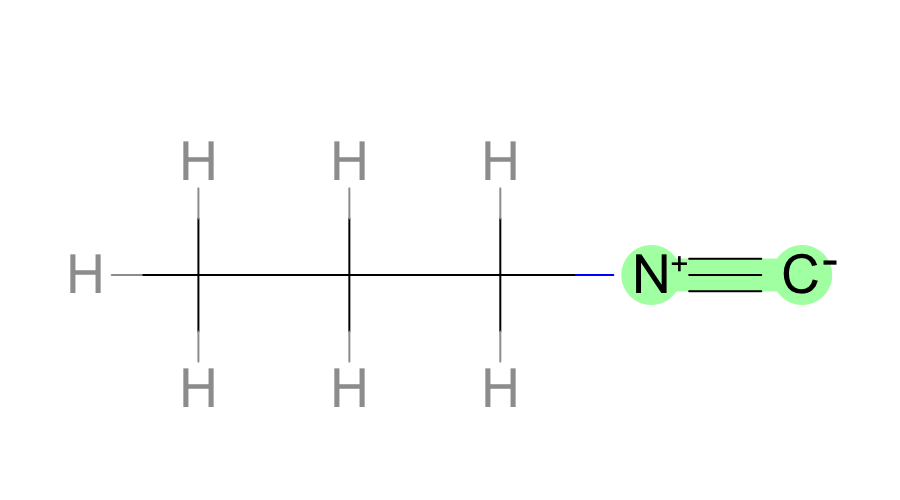




looking at molecule 55
Selected smiles is B(CNC(=O)c1c2ccccc2ccc1OCC)(O)O
Selected IUPAC name guessed: [(2-ethoxynaphthalene-1-carbonyl)amino]methylboronic acid
mol title and NumAtoms:  NBF 36
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 56
Selected smiles is C[C@@H]1Cc2cccc(c2NC1)S(=O)=O
Selected IUPAC name guessed: [(3~{R})-3-methyl-1,2,3,4-tetrahydroquinolin-8-yl]-dioxo-$l^{6}-sulfane
mol title and NumAtoms:  34T 27
Number of times 'b1' appears:   1
Approximate SMARTS: [#16]~[#1]
Current Atom Types: SO~HS


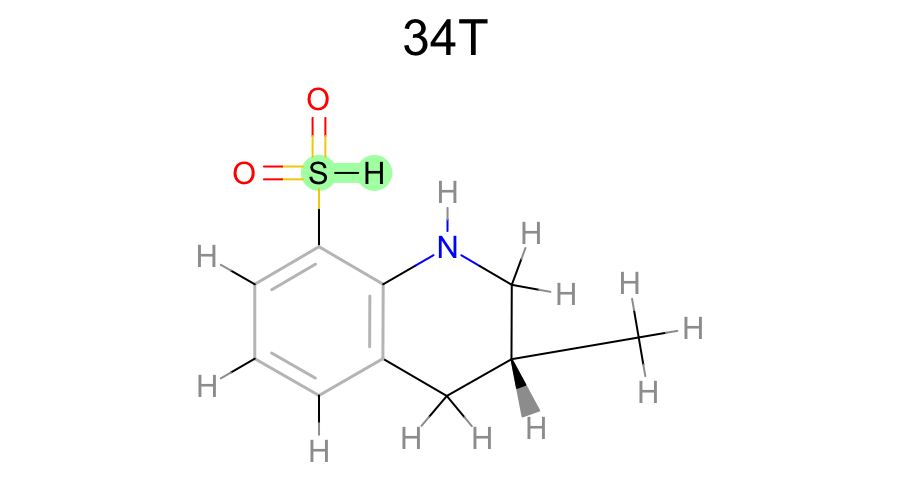




looking at molecule 57
Selected smiles is CCN(C/C=C\c1ccc(c(c1)Cl)C2CCCCC2)C3CCCCC3.Cl
Selected IUPAC name guessed: ~{N}-[(~{Z})-3-(3-chloro-4-cyclohexyl-phenyl)allyl]-~{N}-ethyl-cyclohexanamine;hydrochloride
mol title and NumAtoms:   61
Number of times 'b1' appears:   1
Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


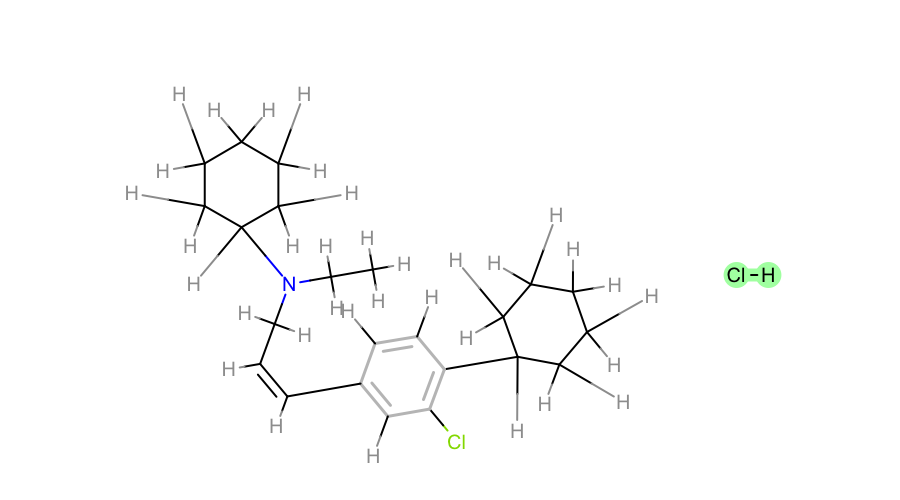




looking at molecule 58
Selected smiles is B1(OCCO1)OCc2ccc(cc2)C(=[NH2+])N
Selected IUPAC name guessed: [amino-[4-(1,3,2-dioxaborolan-2-yloxymethyl)phenyl]methylene]ammonium
mol title and NumAtoms:  SBZ 30
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 59
Selected smiles is C[C@@H](C[C@@H](C(=O)[OH2+])N)C(=O)O
Selected IUPAC name guessed: [(2~{S},4~{S})-2-amino-4-carboxy-pentanoyl]oxonium
mol title and NumAtoms:   23
Number of times 'b1' appears:   1
Approximate SMARTS: [#6]~[#8+1]
Current Atom Types: C~Ou


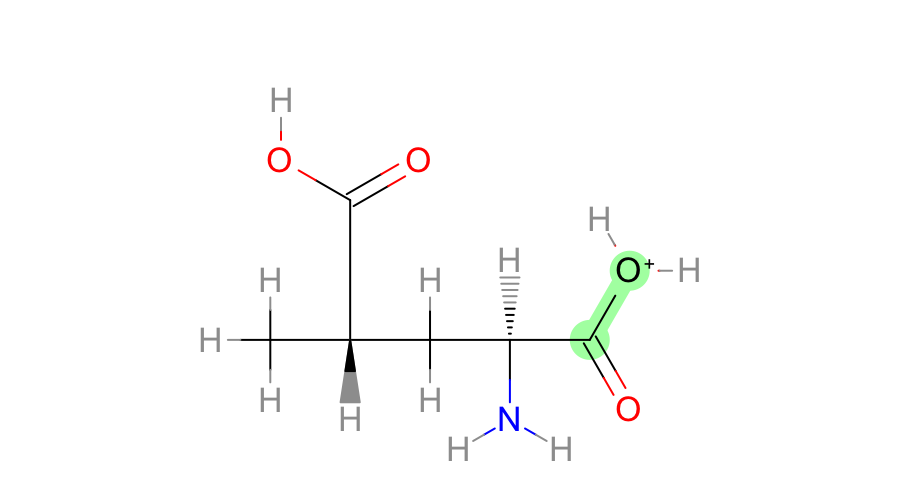




looking at molecule 60
Selected smiles is C[N@+]1(CC[C@@H](CC1)[Si](c2ccccc2)(C)C)[O-]
Selected IUPAC name guessed: dimethyl-(1-methyl-1-oxido-piperidin-1-ium-4-yl)-phenyl-silane
mol title and NumAtoms:  DP4 40
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 61
Selected smiles is C([C@@H](C(=O)O)N)S[SeH]
Selected IUPAC name guessed: (2~{R})-2-amino-3-selanylsulfanyl-propanoic acid
mol title and NumAtoms:   15
Number of times 'b1' appears:   2
This molecule contains 2 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 62
Selected smiles is C(=N[NH3+])(N)N.[Cl-]
Selected IUPAC name guessed: guanidinoammonium;chloride
mol title and NumAtoms:   13
Number of times 'b1' appears:   1
Approximate SMARTS: [#7+1]~[#7]
Current Atom Types: N3~NB


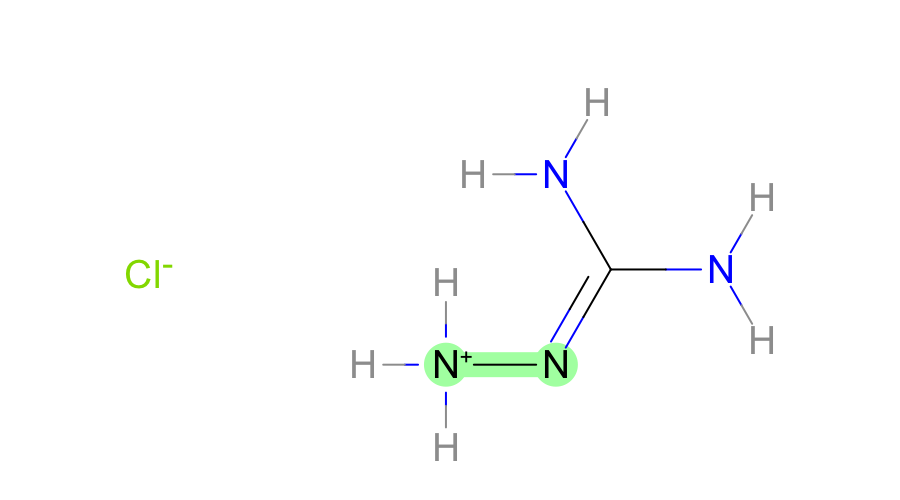




looking at molecule 63
Selected smiles is C[Se]CC(=O)[O-]
Selected IUPAC name guessed: 2-methylselanylacetate
mol title and NumAtoms:   11
Number of times 'b1' appears:   2
This molecule contains 2 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 64
Selected smiles is B([C@H](CCCCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](Cc2ccccc2)NC(=O)C)(O)O
Selected IUPAC name guessed: [(1~{R})-1-[[(2~{S})-1-[(2~{R})-2-acetamido-3-phenyl-propanoyl]pyrrolidine-2-carbonyl]amino]-6-amino-hexyl]boronic acid
mol title and NumAtoms:  DI4 67
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 65
Selected smiles is B([C@H](CCCCN)N)(OCC)OCC
Selected IUPAC name guessed: (1~{R})-1-diethoxyboranylpentane-1,5-diamine
mol title and NumAtoms:  0AY 37
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 66
Selected smiles is B1(OC[C

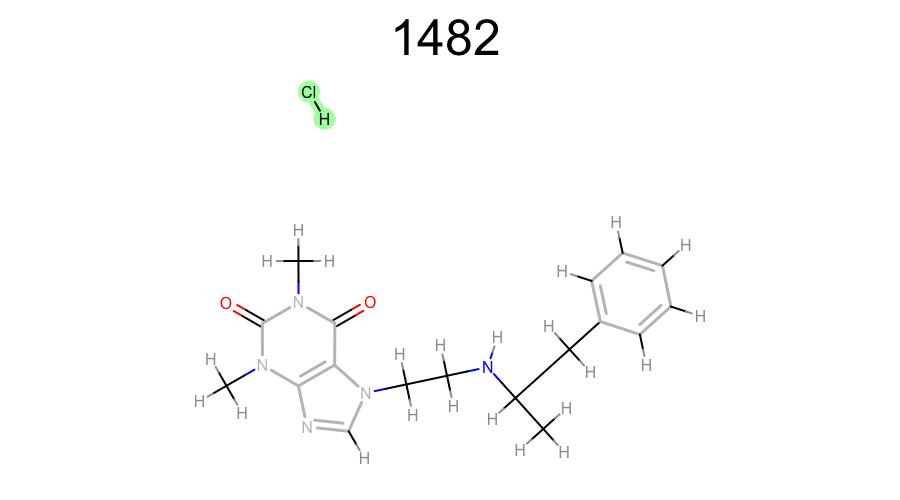




looking at molecule 68
Selected smiles is CCCCCCCCCCCCCCCCS(=O)(=O)F
Selected IUPAC name guessed: hexadecane-1-sulfonyl fluoride
mol title and NumAtoms:   53
Number of times 'b1' appears:   1
Approximate SMARTS: [#16]~[#9]
Current Atom Types: SO~F


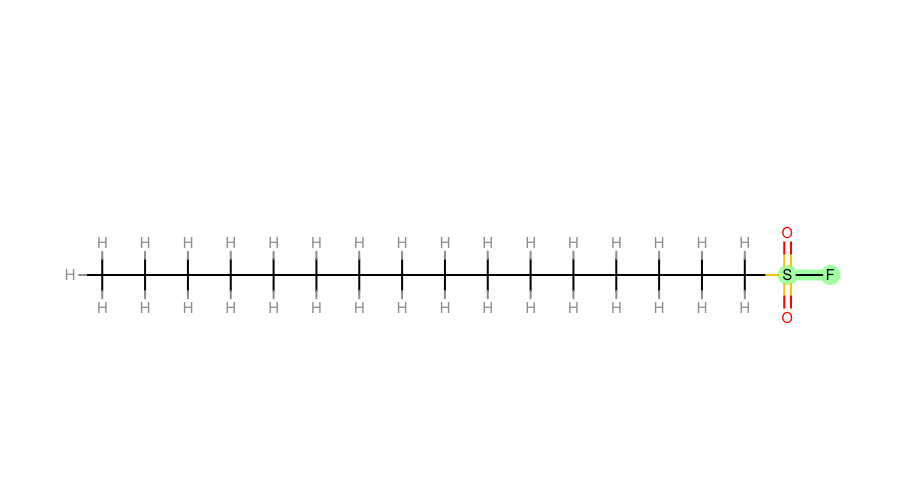




looking at molecule 69
Selected smiles is c1c(c2c(=CC[Se]2)n1)C[C@@H](C(=O)O)N
Selected IUPAC name guessed: (2~{S})-2-amino-3-(2~{H}-selenopheno[3,2-b]pyrrol-6-yl)propanoic acid
mol title and NumAtoms:   24
Number of times 'b1' appears:   2
This molecule contains 2 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 70
Selected smiles is FS(F)(F)(F)(F)F
Selected IUPAC name guessed: hexafluoro-$l^{6}-sulfane
mol title and NumAtoms:   7
Number of times 'b1' appears:   6
Approximate SMARTS: [#9]~[#16]
Current Atom Types: F~Su


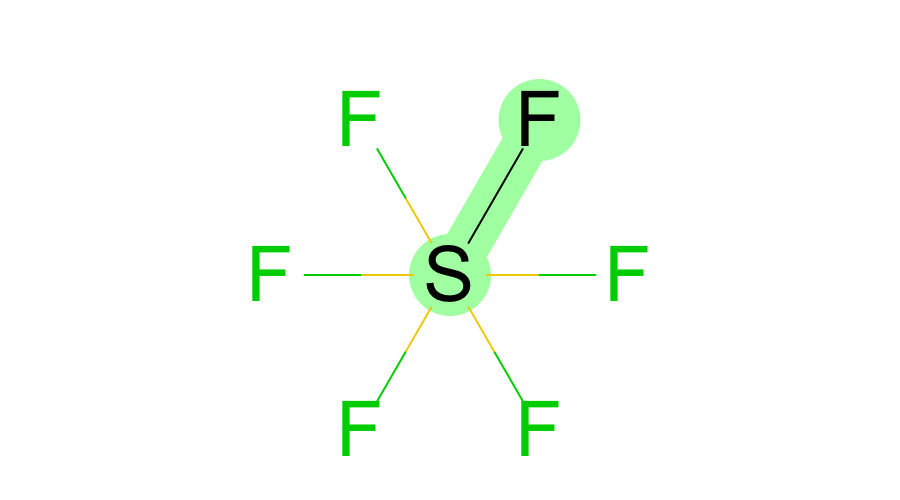

Approximate SMARTS: [#9]~[#16]
Current Atom Types: F~Su


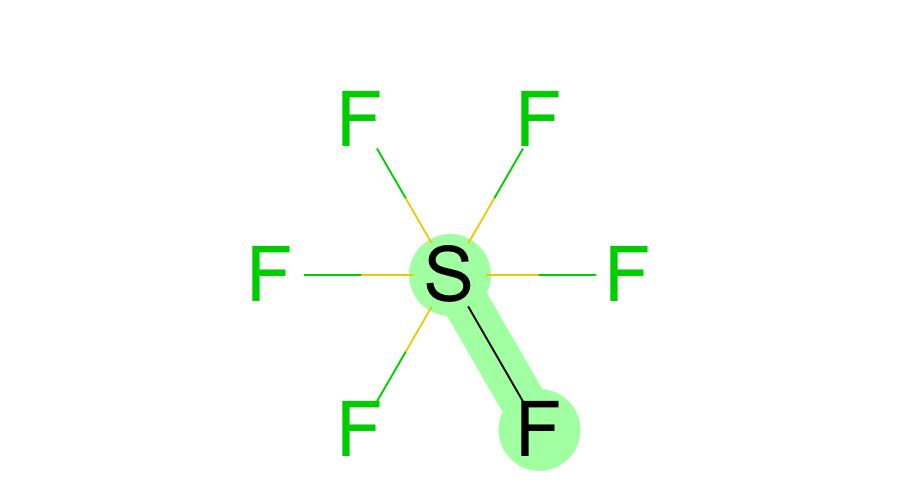

Approximate SMARTS: [#9]~[#16]
Current Atom Types: F~Su


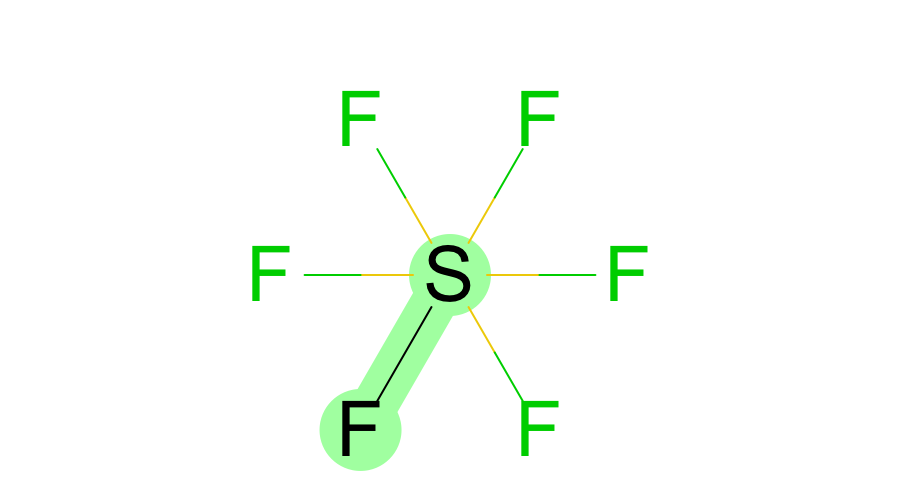

Approximate SMARTS: [#9]~[#16]
Current Atom Types: F~Su


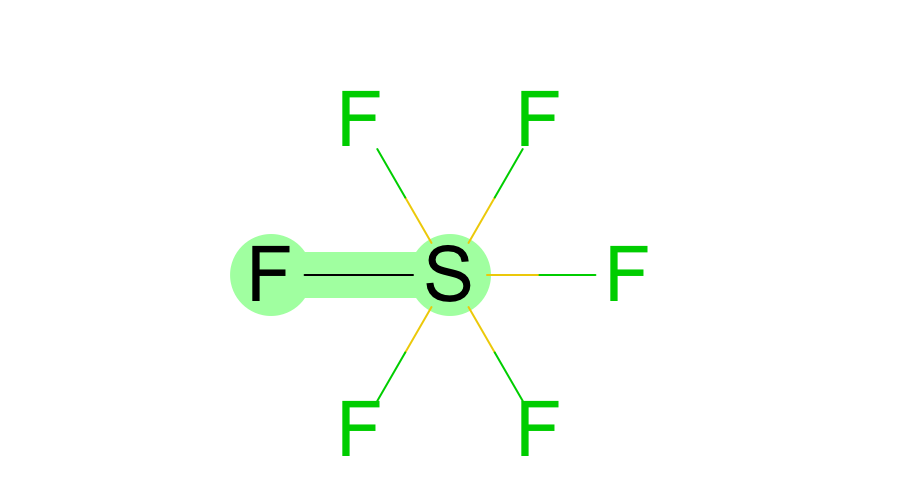

Approximate SMARTS: [#9]~[#16]
Current Atom Types: F~Su


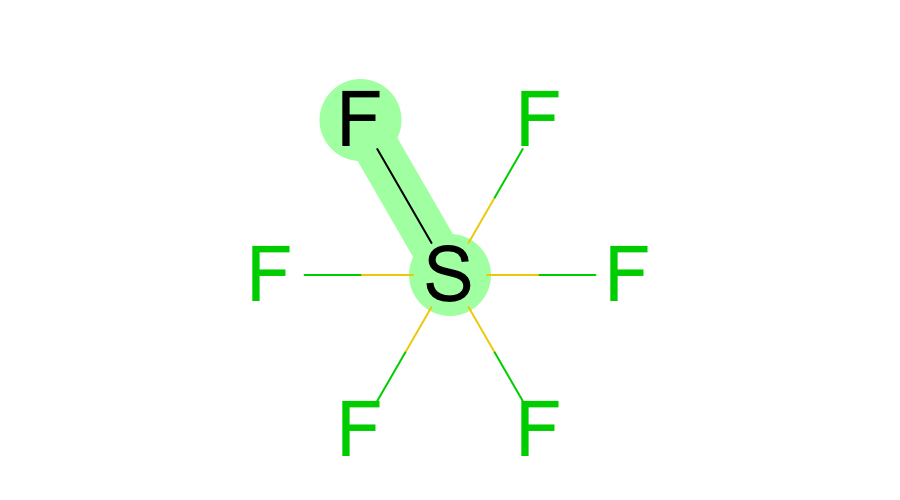

Approximate SMARTS: [#9]~[#16]
Current Atom Types: F~Su


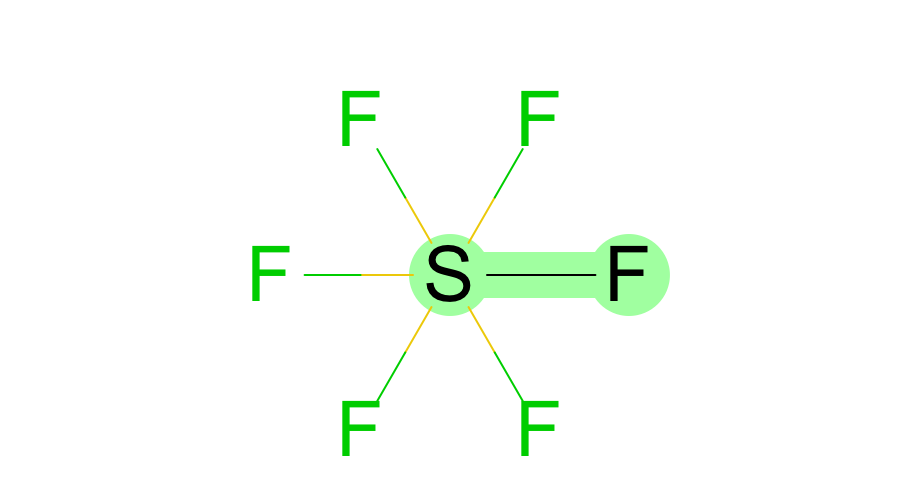




looking at molecule 71
Selected smiles is B(CNC(=O)Cc1cccs1)(O)O
Selected IUPAC name guessed: [[2-(2-thienyl)acetyl]amino]methylboronic acid
mol title and NumAtoms:  CTB 23
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 72
Selected smiles is B(c1ccccc1)(O)O
Selected IUPAC name guessed: phenylboronic acid
mol title and NumAtoms:   16
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 73
Selected smiles is CCCCCCCCCCNCCN[C@]1(C[C@@H](O[C@H]([C@H]1O)C)O[C@@H]2[C@H]([C@@H]([C@H](O[C@H]2Oc3c4cc5cc3Oc6ccc(cc6Cl)[C@H]([C@H](C(=O)N[C@H](C(=O)N[C@H]5C(=O)N[C@@H]7c8ccc(c(c8)-c9c(cc(c(c9O)CNCP(=O)(O)O)O)[C@H](NC(=O)[C@H]([C@@H](c1ccc(c(c1)Cl)O4)O)NC7=O)C(=O)O)O)CC(=O)N)NC(=O)[C@@H](CC(C)C)NC)O)CO)O)O)C.Cl
Selected IUPAC name guessed: (2-amino-2-oxo-ethyl)-dichloro-[(2~{S},3~{R},4~{S},5~{S},6~{R})-3-[(2~{S},4~{S},5~{S},6~{S})

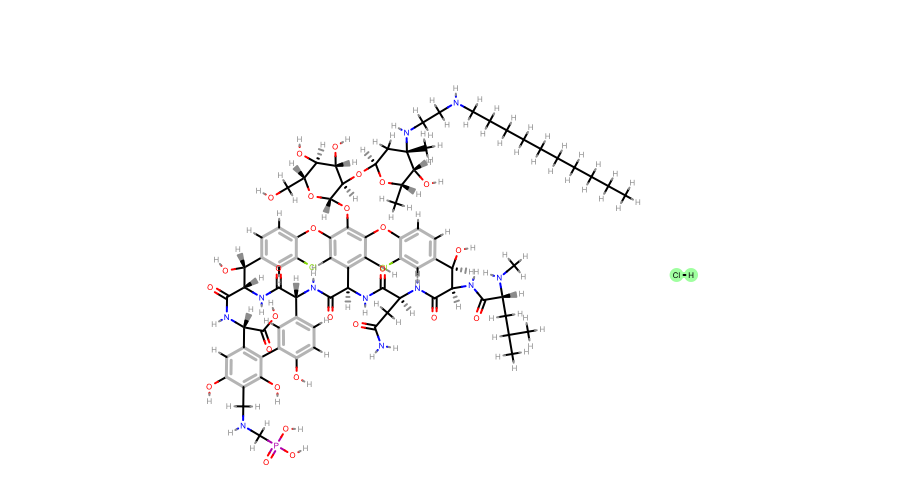




looking at molecule 74
Selected smiles is c1cc2c(c(c1N)Cl(=O)=O)c(nc(n2)N)N
Selected IUPAC name guessed: 5-chlorylquinazoline-2,4,6-triamine
mol title and NumAtoms:  CLZ 24
Number of times 'b1' appears:   2
Approximate SMARTS: [#17]~[#8]
Current Atom Types: CL~Ou


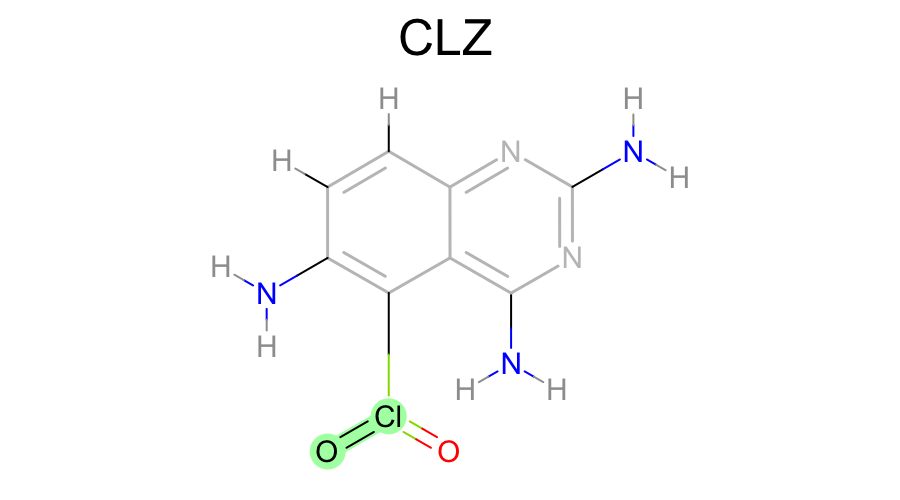

Approximate SMARTS: [#17]~[#8]
Current Atom Types: CL~Ou


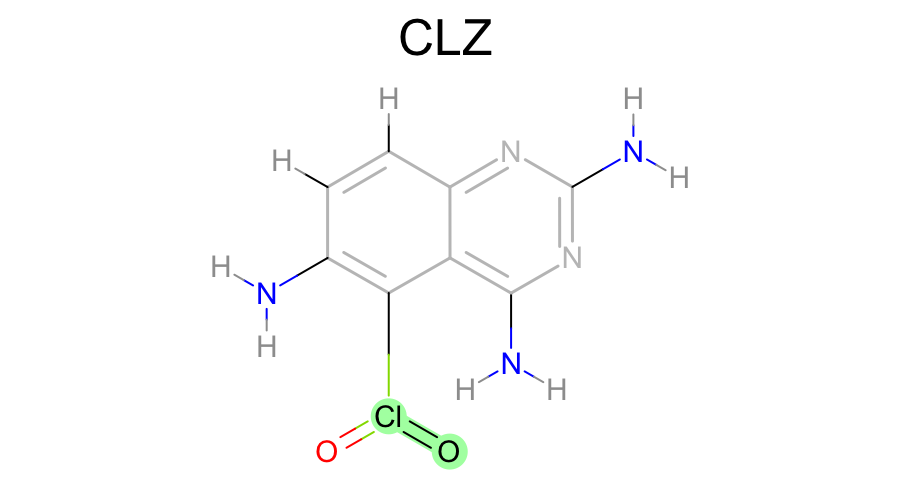




looking at molecule 75
Selected smiles is C[Te]CC(=O)[O-]
Selected IUPAC name guessed: 2-methyltellanylacetate
mol title and NumAtoms:   11
Number of times 'b1' appears:   2
Approximate SMARTS: [#6]~[#52]
Current Atom Types: CT~gg


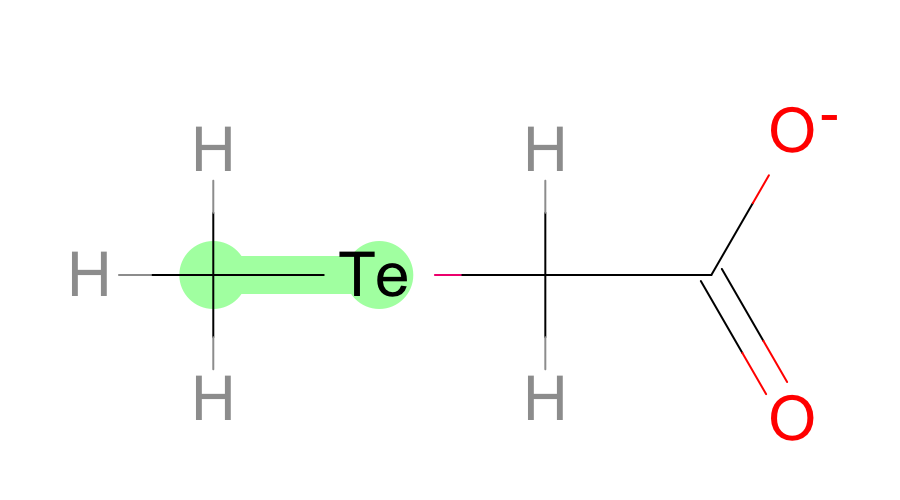

Approximate SMARTS: [#52]~[#6]
Current Atom Types: gg~CT


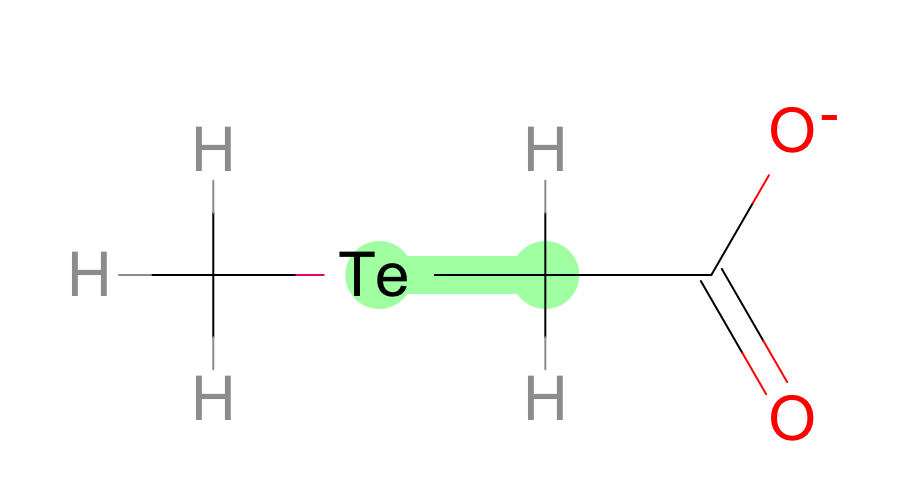




looking at molecule 76
Selected smiles is B(c1cccc(c1)[N+](=O)[O-])(O)O
Selected IUPAC name guessed: (3-nitrophenyl)boronic acid
mol title and NumAtoms:   18
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 77
Selected smiles is B([C@H](CC(C)C)NC(=O)[C@H](Cc1ccccc1)NC(=O)c2cnccn2)(O)O
Selected IUPAC name guessed: [(1~{R})-3-methyl-1-[[(2~{S})-3-phenyl-2-(pyrazine-2-carbonylamino)propanoyl]amino]butyl]boronic acid
mol title and NumAtoms:   53
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 78
Selected smiles is B([C@H](CC(C)C)/N=C(/C/N=C(/c1cc(ccc1Cl)Cl)\O)\O)(O)O
Selected IUPAC name guessed: (1~{Z})-~{N}-[(2~{Z})-2-[(1~{R})-1-borono-3-methyl-butyl]imino-2-hydroxy-ethyl]-2,5-dichloro-benzimidic acid
mol title and NumAtoms:   42
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least on

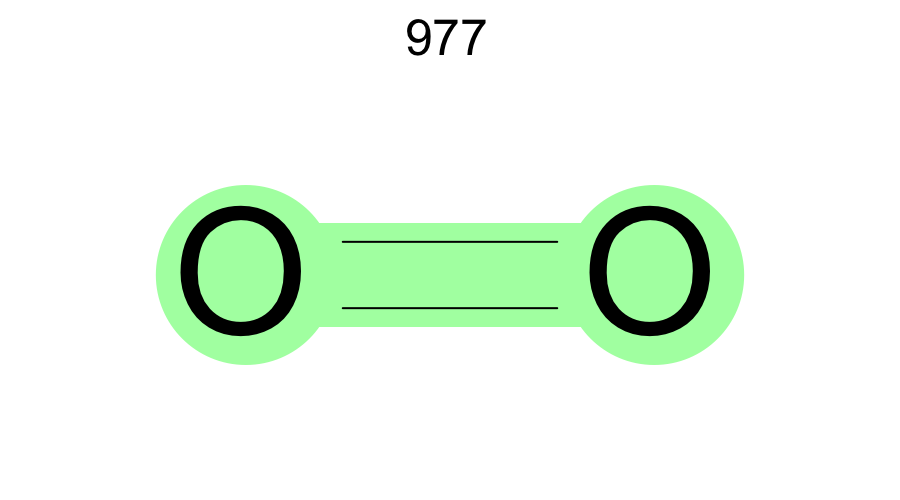




looking at molecule 87
Selected smiles is c1ccc2c(c1)CCn3c(cnc3C24CCNCC4)C(=O)N.Cl.Cl
Selected IUPAC name guessed: spiro[5,6-dihydroimidazo[2,1-b][3]benzazepine-11,4'-piperidine]-3-carboxamide;dihydrochloride
mol title and NumAtoms:   46
Number of times 'b1' appears:   2
Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


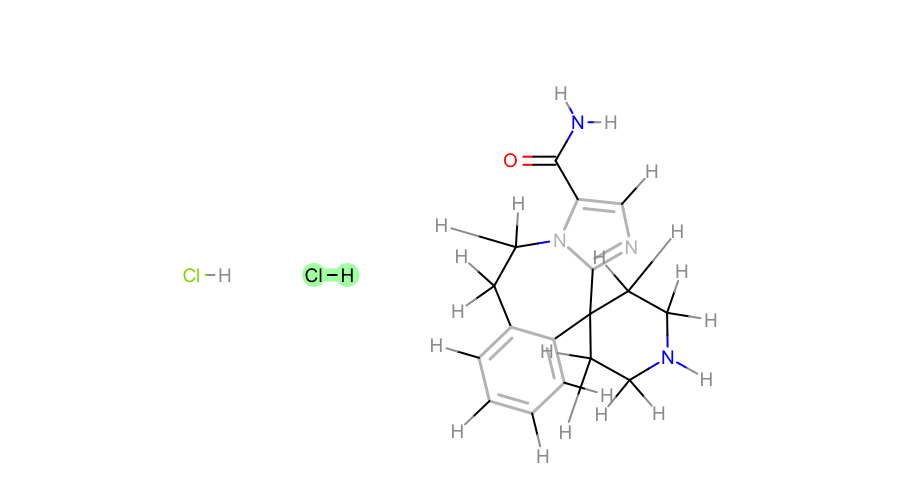

Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


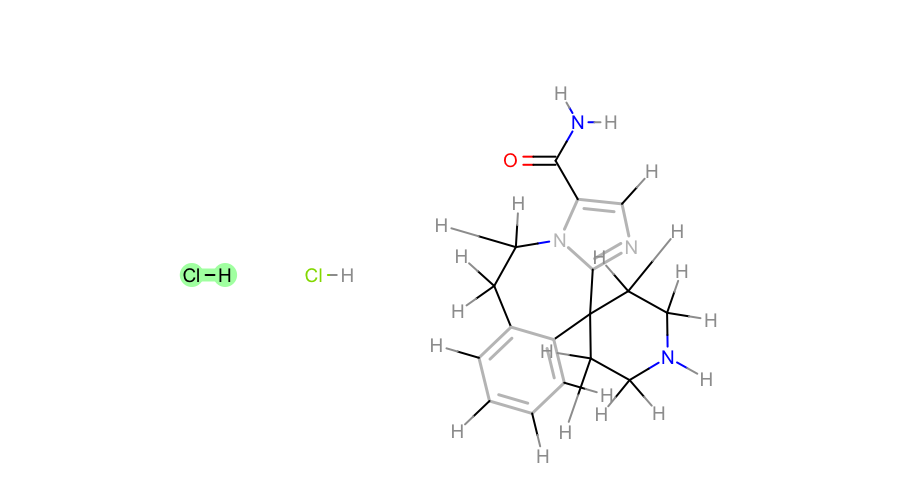




looking at molecule 88
Selected smiles is CNC1=Nc2ccc(cc2C(=N(=O)C1)c3ccccc3)Cl
Selected IUPAC name guessed: 9-chloro-~{N}-methyl-5-oxo-6-phenyl-2,5$l^{5}-diazabicyclo[5.4.0]undeca-1(7),2,5,8,10-pentaen-3-amine
mol title and NumAtoms:   35
Number of times 'b1' appears:   1
Approximate SMARTS: [#6]~[#7]
Current Atom Types: C~N3


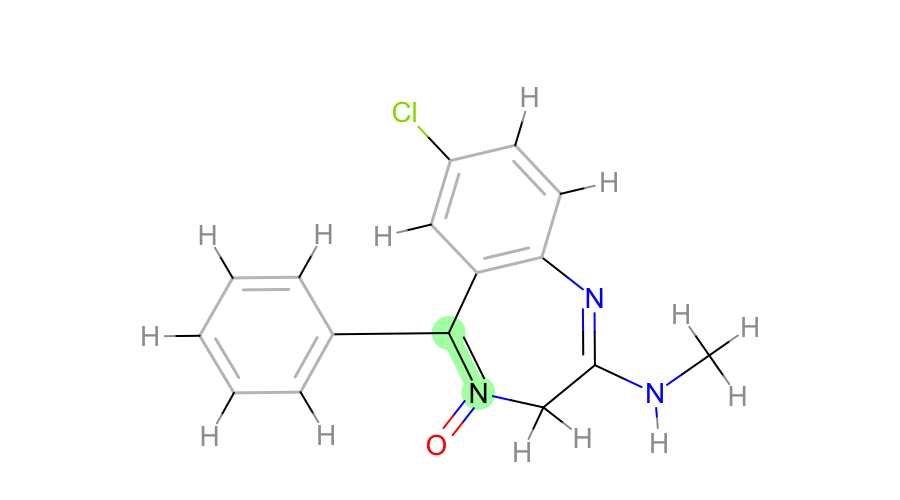




looking at molecule 89
Selected smiles is c1ccc2c(c1)OC[C@@H](O2)CNCCCOc3ccc4c(c3)OCO4.Cl
Selected IUPAC name guessed: 3-(1,3-benzodioxol-5-yloxy)-~{N}-[[(3~{S})-2,3-dihydro-1,4-benzodioxin-3-yl]methyl]propan-1-amine;hydrochloride
mol title and NumAtoms:   48
Number of times 'b1' appears:   1
Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


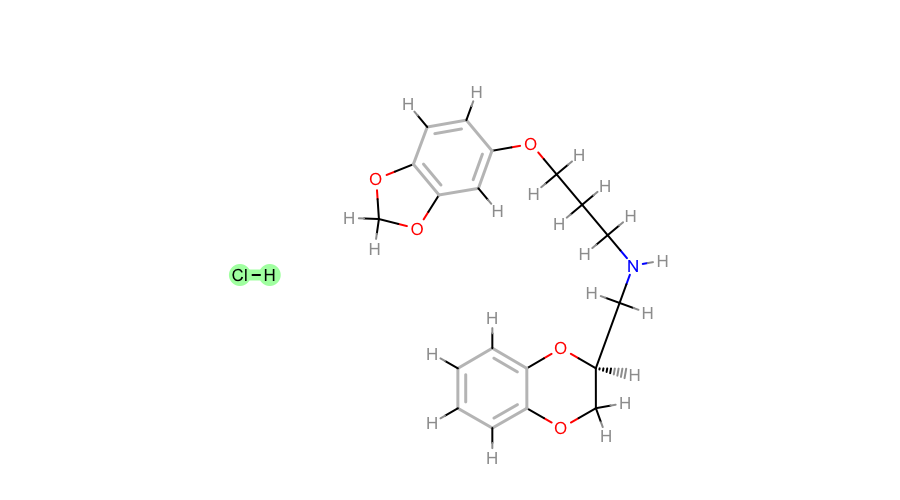




looking at molecule 90
Selected smiles is B([C@H](c1ccccc1)NC(=O)Cc2cccs2)(O)O
Selected IUPAC name guessed: [(~{R})-phenyl-[[2-(2-thienyl)acetyl]amino]methyl]boronic acid
mol title and NumAtoms:  SM3 33
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 91
Selected smiles is CCOC(CN1CCN(CC1)CC(C)C(=O)c2ccccc2)c3ccccc3.Cl.Cl
Selected IUPAC name guessed: 3-[4-(2-ethoxy-2-phenyl-ethyl)piperazin-1-yl]-2-methyl-1-phenyl-propan-1-one;dihydrochloride
mol title and NumAtoms:   64
Number of times 'b1' appears:   2
Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


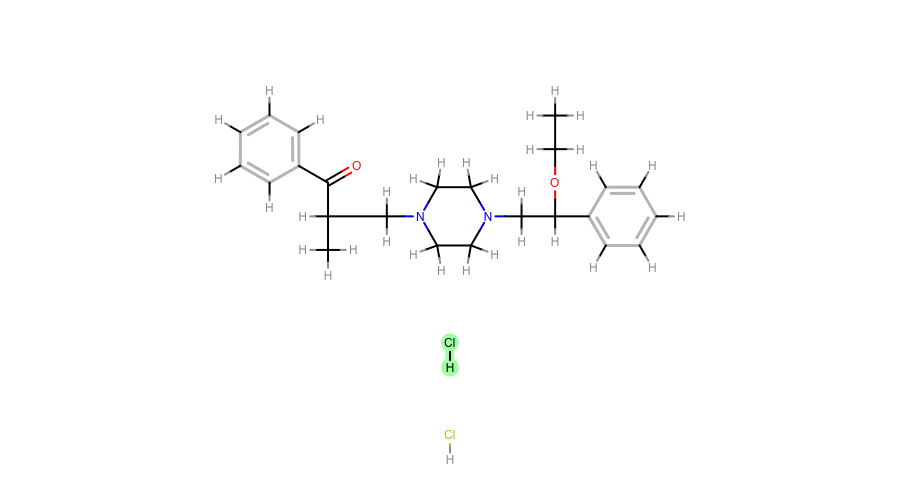

Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


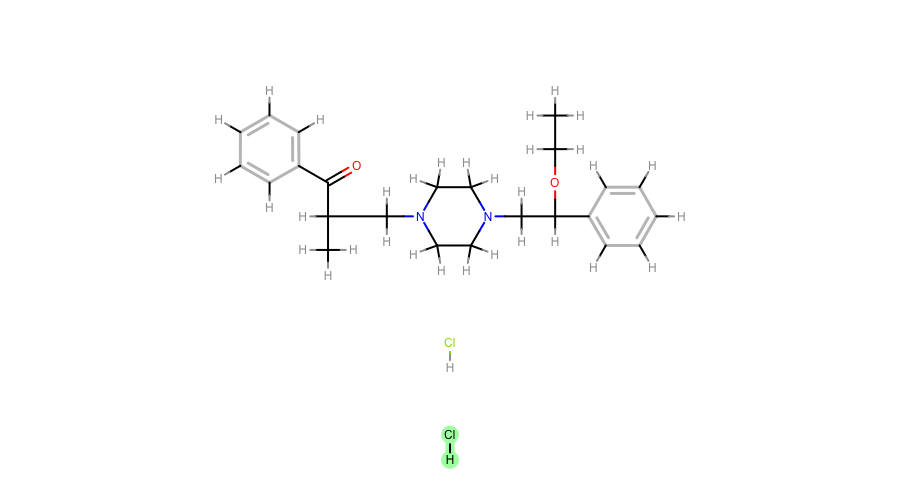




looking at molecule 92
Selected smiles is C(=O)=O
Selected IUPAC name guessed: carbon dioxide
mol title and NumAtoms:   3
Number of times 'b1' appears:   2
Approximate SMARTS: [#6]~[#8]
Current Atom Types: C2~Ou


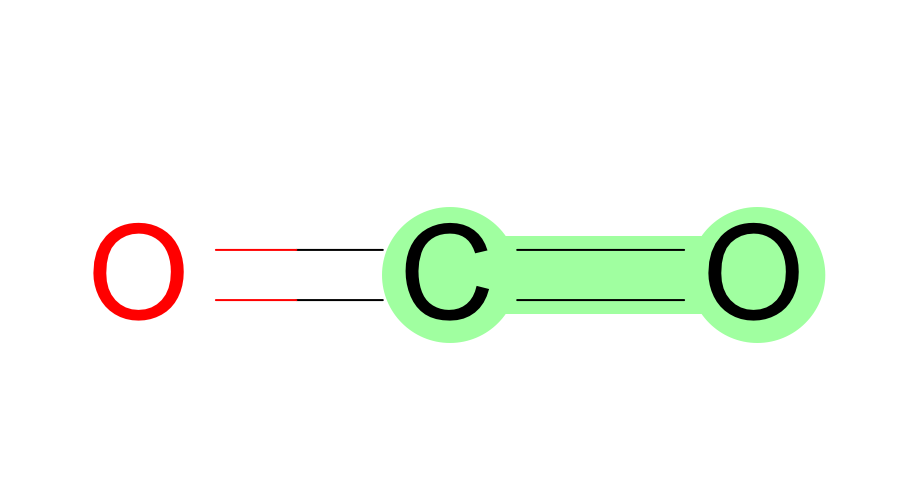

Approximate SMARTS: [#6]~[#8]
Current Atom Types: C2~Ou


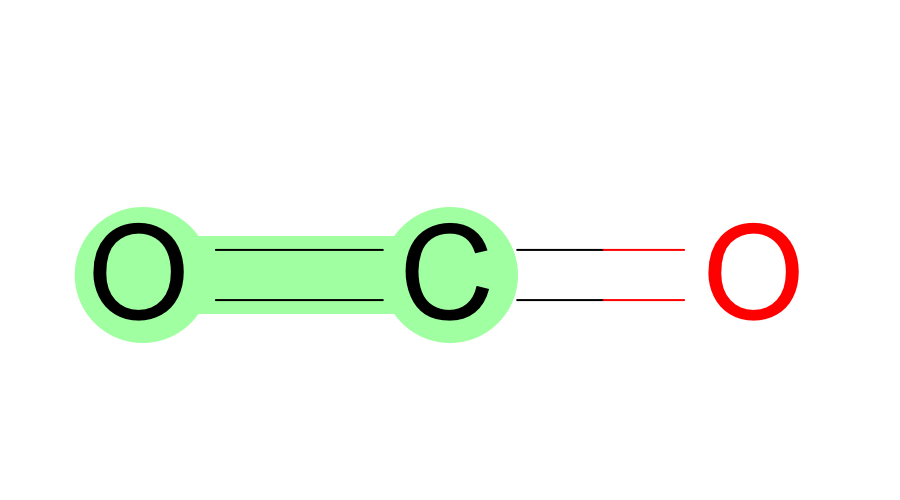




looking at molecule 93
Selected smiles is B([C@H](CCCN)NC(=O)[C@@H]1CCCN1C(=O)[C@@H](Cc2ccccc2)NC(=O)C)(O)O
Selected IUPAC name guessed: [(1~{R})-1-[[(2~{S})-1-[(2~{R})-2-acetamido-3-phenyl-propanoyl]pyrrolidine-2-carbonyl]amino]-4-amino-butyl]boronic acid
mol title and NumAtoms:  DI5 61
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 94
Selected smiles is II
Selected IUPAC name guessed: molecular iodine
mol title and NumAtoms:   2
Number of times 'b1' appears:   1
Approximate SMARTS: [#53]~[#53]
Current Atom Types: I~I


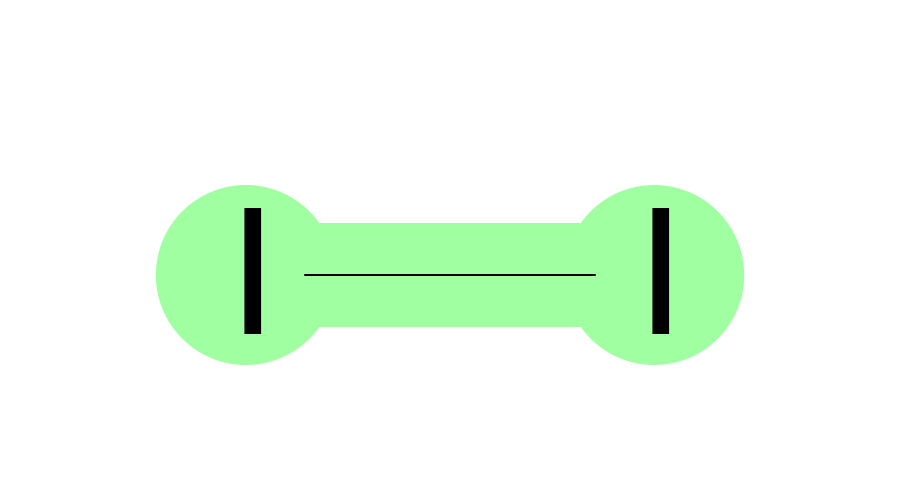




looking at molecule 95
Selected smiles is B1(c2ccccc2C=NN1S(=O)(=O)c3ccc(cc3)C)O
Selected IUPAC name guessed: 1-hydroxy-2-(p-tolylsulfonyl)-2,3,1-benzodiazaborinine
mol title and NumAtoms:  NDT 34
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 96
Selected smiles is B(CNC(=O)/C(=N\OC(C)(C)C(=O)O)/c1csc(n1)N)(O)O
Selected IUPAC name guessed: 2-[(~{Z})-[1-(2-aminothiazol-4-yl)-2-(boronomethylamino)-2-oxo-ethylidene]amino]oxy-2-methyl-propanoic acid
mol title and NumAtoms:  CB4 37
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 97
Selected smiles is c1cc(c2c3c1C[C@@H]4[C@]5([C@]3(CCN4CC6CC6)[C@@H](O2)C(=O)CC5)O)O.Cl
Selected IUPAC name guessed: (4~{R},4~{a}~{S},7~{a}~{R},12~{b}~{S})-3-(cyclopropylmethyl)-4~{a},9-dihydroxy-2,4,5,6,7~{a},13-hexahydro-1~{H}-4,12-methanobenzofuro[3,2-e]isoquinolin-7-one;hydrochloride
m

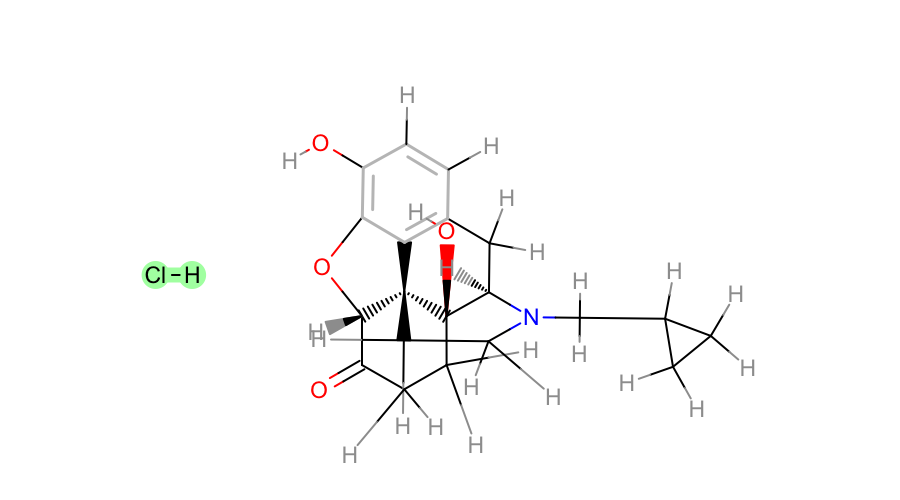




looking at molecule 98
Selected smiles is CC(C)(C)OC(=O)N[C@@H](Cc1ccc(cc1)C[Se](=O)O)C(=O)OC
Selected IUPAC name guessed: [4-[(2~{S})-2-(~{tert}-butoxycarbonylamino)-3-methoxy-3-oxo-propyl]phenyl]methaneseleninic acid
mol title and NumAtoms:  ZYZ 47
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 99
Selected smiles is B1(OC[C@H](O1)CO)c2ccc(cc2)[C@H](CNC(=N)N)OC(=O)c3cccnc3
Selected IUPAC name guessed: [(1~{R})-2-guanidino-1-[4-[(4~{R})-4-(hydroxymethyl)-1,3,2-dioxaborolan-2-yl]phenyl]ethyl] pyridine-3-carboxylate
mol title and NumAtoms:  368 49
Number of times 'b1' appears:   3
This molecule contains 3 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 100
Selected smiles is [B-]([C@@H](Cc1ccc(cc1)Cl)NC(=O)C)(O)(O)OC[C@@H](C(=O)O)N
Selected IUPAC name guessed: [(1~{S})-1-acetamido-2-(4-chlorophenyl)ethyl]-[(2~{S})-2-amino-2-carboxy-ethoxy]-dihydroxy-boranuide
mol title a

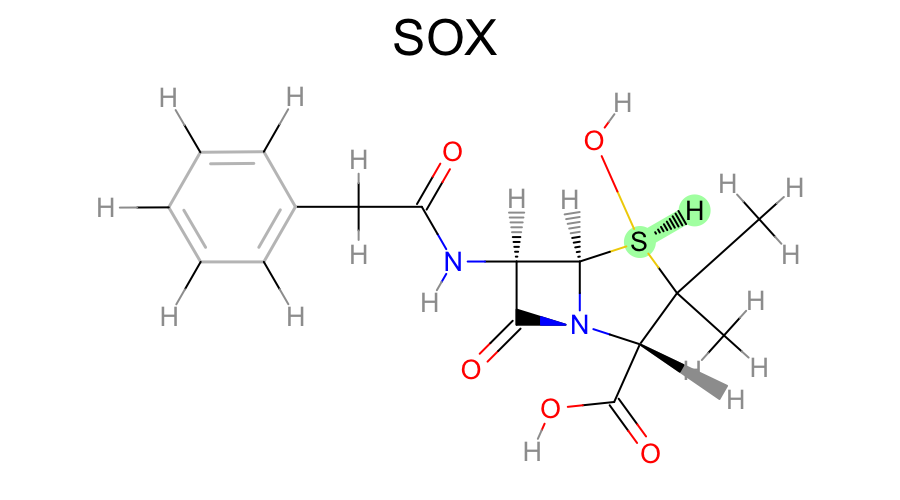




looking at molecule 106
Selected smiles is CN(C)CCN(Cc1cccs1)c2ccccn2.Cl
Selected IUPAC name guessed: ~{N},~{N}-dimethyl-~{N}'-(2-pyridyl)-~{N}'-(2-thienylmethyl)ethane-1,2-diamine;hydrochloride
mol title and NumAtoms:  4819 39
Number of times 'b1' appears:   1
Approximate SMARTS: [#17]~[#1]
Current Atom Types: CL~HC


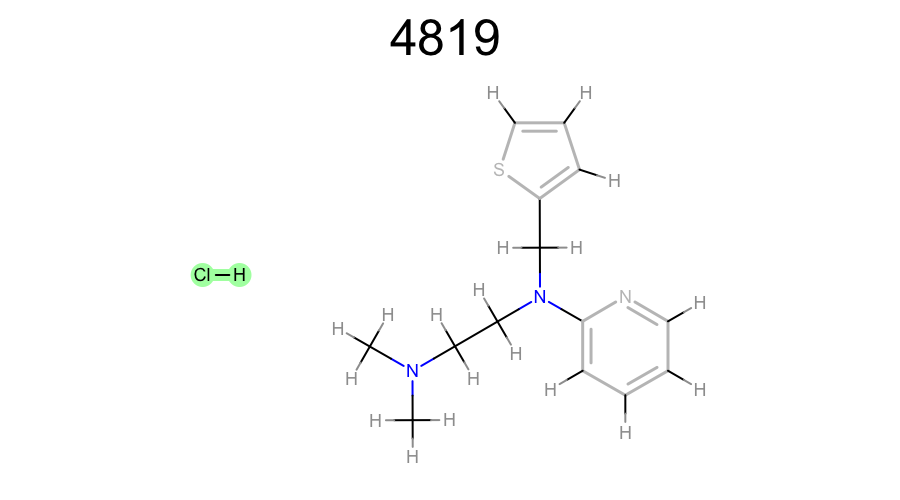




looking at molecule 107
Selected smiles is C[As+](C)(C)CCO[C@@H](c1ccccc1[N+](=O)O)C(F)(F)F
Selected IUPAC name guessed: hydroxy-oxo-[2-[(1~{S})-2,2,2-trifluoro-1-(2-trimethylarsoniumylethoxy)ethyl]phenyl]ammonium
mol title and NumAtoms:  CFQ 40
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 108
Selected smiles is [B-](/C=C/CC[C@@H](C(=O)O)N)(O)(O)O
Selected IUPAC name guessed: [(~{E},5~{S})-5-amino-5-carboxy-pent-1-enyl]-trihydroxy-boranuide
mol title and NumAtoms:   26
Number of times 'b1' appears:   4
This molecule contains 4 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 109
Selected smiles is CCCCC1=NC(=[Se]=C1CCC)N
Selected IUPAC name guessed: 4-butyl-5-propyl-1,3-selenazol-2-amine
mol title and NumAtoms:   31
Number of times 'b1' appears:   2
This molecule contains 2 fragment(s) with at least one atom in (2,5,14,33,34)



looking at molecule 110
Selected smiles

In [21]:
lowerlimit = 0
upperlimit = 150

# Skip showing molecule if the highlighted parameter 
# includes an element we know we don't have parameters for
skip_atoms = [2, 5, 14,33, 34] 

# Correct with list of molecules is less than upper limit
if len(mols_with_param) < upperlimit:
    upperlimit = len(mols_with_param)
    
print("\nDepicting molecules %i to %i with parameter '%s'\n\n" % (lowerlimit,upperlimit, parameter_id))    

# Show molecules form lower to upper limit highlighting fragment with the parameter_id
for idx in range(lowerlimit, upperlimit):
    smiles = mols_with_param[idx][0]
    mol = mols_with_param[idx][1]
    skip_it = False
    OEAddExplicitHydrogens(mol)
    indice_list = parameters_by_molecule[smiles][parameter_id]
    print("looking at molecule %i" % idx)
    print('Selected smiles is %s' % smiles)
    print('Selected IUPAC name guessed: %s' % oeiupac.OECreateIUPACName(mol) )
    print( 'mol title and NumAtoms: ', mol.GetTitle(), mol.NumAtoms() )
    print( "Number of times '%s' appears:   %i" % (parameter_id, len(indice_list))) 
    DepictMolWithParam( mol, indice_list, supH = False, skip_atoms=skip_atoms)
    print()
    print()
    print()
    